# Import Libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.cluster import KMeans

from sklearn.metrics.cluster import v_measure_score

from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import silhouette_score

from scipy.spatial.distance import cdist

from joblib import Parallel
from joblib import delayed

from tqdm_joblib import tqdm_joblib

from tqdm.autonotebook import tqdm

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
warnings.filterwarnings("ignore")

os.environ["PYTHONWARNINGS"] = "ignore"

pd.set_option('display.max_columns', 50)

In [3]:
path_to_save = './../results/03b_clustering'

# Loading data

## Train data

In [4]:
path_to_ftir_data = './../data/processed_data/ftir_engineered_features_train_scaled.csv'

In [5]:
engineered_data = pd.read_csv(path_to_ftir_data, index_col=0)

# data.index = data.index.astype(str)

print(engineered_data.shape)
engineered_data.head(3)

(25, 81)


$(ΣI)_{n}$  $(ΣS)_{n}$  $I_{1619, n}$  $S_{1619, n}$  $I_{1720, n}$  \
1    0.470229    0.654616       0.503627       0.041810       1.000000   
2    0.892751    0.376269       0.570531       0.312727       0.662535   
3    0.448664    0.327503       0.192870       0.200354       0.427848   

   $S_{1720, n}$  $(\frac{ΣI}{ΣS})_{n}$  $(\frac{ΣI}{I_{1619}})_{n}$  \
1       1.000000               0.207682                     0.358991   
2       0.028331               0.714047                     0.532875   
3       0.149109               0.452003                     0.777867   

   $(\frac{ΣI}{S_{1619}})_{n}$  $(\frac{ΣI}{I_{1720}})_{n}$  \
1                     0.684516                     0.000000   
2                     0.222842                     0.303321   
3                     0.229123                     0.294096   

   $(\frac{ΣI}{S_{1720}})_{n}$  $(\frac{ΣS}{I_{1619}})_{n}$  \
1                     0.000000                     0.583143   
2                     0.194305                     0.326213   
3                     0.025395                     0.713763   

   $(\frac{ΣS}{S_{1619}})_{n}$  $(\frac{ΣS}{I_{1720}})_{n}$  \
1                     0.910700                     0.065741   
2                     0.160813                     0.078640   
3                     0.233788                     0.176914   

   $(\frac{ΣS}{S_{1720}})_{n}$  $(\frac{I_{1619}}{S_{1619}})_{n}$  \
1                     0.000000                           0.819064   
2                     0.071507                           0.153009   
3                     0.011491                           0.084991   

   $(\frac{I_{1619}}{I_{1720}})_{n}$  $(\frac{I_{1619}}{S_{1720}})_{n}$  \
1                           0.024632                           0.000000   
2                           0.119753                           0.075344   
3                           0.053522                           0.006893   

   $(\frac{S_{1619}}{I_{1720}})_{n}$  $(\frac{S_{1619}}{S_{1720}})_{n}$  \
1                           0.016069                           0.000000   
2                           0.229625                           0.135539   
3                           0.220679                           0.018950   

   $(\frac{I_{1720}}{S_{1720}})_{n}$  $(ΣI^{-1})_{n}$  $(ΣI^2)_{n}$  \
1                           0.000000         0.322522      0.369109   
2                           0.260310         0.048311      0.853886   
3                           0.029841         0.341783      0.348254   

   $(ΣI^{-2})_{n}$  $(ΣI^3)_{n}$  ...  $(S_{1619}^{-5})_{n}$  \
1         0.233828      0.280063  ...               0.119258   
2         0.029648      0.811236  ...               0.000330   
3         0.250464      0.260944  ...               0.001797   

   $(I_{1720}^{-1})_{n}$  $(I_{1720}^2)_{n}$  $(I_{1720}^{-2})_{n}$  \
1               0.000000            1.000000               0.000000   
2               0.086925            0.509369               0.032552   
3               0.199962            0.260150               0.090369   

   $(I_{1720}^3)_{n}$  $(I_{1720}^{-3})_{n}$  $(I_{1720}^4)_{n}$  \
1            1.000000               0.000000            1.000000   
2            0.377977               0.010630            0.276327   
3            0.147379               0.036397            0.080671   

   $(I_{1720}^{-4})_{n}$  $(I_{1720}^5)_{n}$  $(I_{1720}^{-5})_{n}$  \
1               0.000000            1.000000               0.000000   
2               0.003186            0.200964               0.000906   
3               0.013716            0.043524               0.004987   

   $(S_{1720}^{-1})_{n}$  $(S_{1720}^2)_{n}$  $(S_{1720}^{-2})_{n}$  \
1               0.000000            1.000000               0.000000   
2               0.102873            0.000986               0.011198   
3               0.018722            0.023079               0.000473   

   $(S_{1720}^3)_{n}$  $(S_{1720}^{-3})_{n}$  $(S_{1720}^4)_{n}$  \
1            1.000000               0.000

## Samples description

In [6]:
path_to_samples_description = './../data/preprocessed_data/ftir_description.csv'

In [7]:
samples_description = pd.read_csv(path_to_samples_description, index_col=0)

# samples_description.index = samples_description.index.astype(str)

print(samples_description.shape)
samples_description.head(3)

(29, 4)


Description  Type  Class  Label
1                    MFGO, разб. 1:20  $GO$      1  Train
2           HGO, 0.0116 г в 25 мл H2O  $GO$      1  Train
3  GO, RusGraphene, 2 г в 1000 мл H2O  $GO$      1  Train

# Dataset wrangling

## Selecting *Train* part of `samples_description`

In [8]:
samples_description = samples_description.loc[samples_description['Label'] == 'Train']

print(samples_description.shape)
samples_description.head(3)

(25, 4)


Description  Type  Class  Label
1                    MFGO, разб. 1:20  $GO$      1  Train
2           HGO, 0.0116 г в 25 мл H2O  $GO$      1  Train
3  GO, RusGraphene, 2 г в 1000 мл H2O  $GO$      1  Train

## Additional mapping columns `Type`

In [9]:
# type_dict = {
#     '$rGO$': '$вОГ$',
#     '$GO$': '$ОГ$',
#     '$GO_{d}$': '$ОГ_{диализ}$',
# }

# samples_description['Type'] = samples_description['Type'].apply(lambda x: type_dict[x])

# print(samples_description.shape)
# samples_description.head(3)

# Clustering & Feature Analysis

## Class for clustering

In [10]:
class ClusterAnalysis2D:
    def __init__(self, target=None, hue=None):
        self.target = target
        self.hue = hue

    def fit_transform_kmeans(self, train_data, n_clusters, random_state=42):
        self.train_data = train_data
        self.n_clusters = n_clusters
        
        self.estimator = KMeans(n_clusters=n_clusters, init='k-means++', random_state=random_state)
        self.estimator.fit(train_data)

        predictions = pd.Series(self.estimator.predict(train_data), index=train_data.index, name="Predictions")
        self.predictions = predictions
        self.train_data_predictions = pd.concat([train_data, predictions], axis=1)

    def get_metric(self, metric_func, requires_target=True):
        if requires_target and self.target is None:
            return None
        return metric_func(self)  # Теперь передаём self, чтобы использовать нужные атрибуты
    
    def get_homogeneity(self):
        return self.get_metric(lambda self: homogeneity_score(self.target, self.predictions))

    def get_completeness(self):
        return self.get_metric(lambda self: completeness_score(self.target, self.predictions))

    def get_v_measure(self):
        return self.get_metric(lambda self: v_measure_score(self.target, self.predictions))

    def get_wccs(self):
        return self.get_metric(lambda self: self.estimator.inertia_, requires_target=False)

    def get_silhouette_score(self):
        return self.get_metric(
            lambda self: silhouette_score(self.train_data, self.estimator.labels_) if self.n_clusters >= 2 else None,
            requires_target=False
        )

    def get_avg_intercluster_distance(self):
        cluster_centers = self.estimator.cluster_centers_
        if self.n_clusters < 2:
            return None  # Не имеет смысла для 1 кластера
        
        distances = cdist(cluster_centers, cluster_centers)
        np.fill_diagonal(distances, np.nan)  # Игнорируем расстояния до самого себя
        return np.nanmean(distances)

    def optimize_n_clusters(self, train_data, metric='silhouette', max_n_clusters=None):
        max_n_clusters = max_n_clusters or train_data.shape[0] // 2
        metrics = {
            'silhouette': self.get_silhouette_score,
            'v_measure': self.get_v_measure
        }

        best_n, best_score = None, float('-inf')
        for n_clusters in range(2, max_n_clusters + 1):
            self.fit_transform_kmeans(train_data, n_clusters)
            score = metrics[metric]()
            if score is not None and score > best_score:
                best_n, best_score = n_clusters, score

        return best_n

    def get_clustering_visualization(self, figsize=(11, 7.5), markersize=14, palette='Dark2', color=None,
                                     fontsize=None, print_point_labels=False, filter_class=None,
                                     path_to_save=None, dpi=300):
        
        vis_data = self.train_data_predictions
        x_col, y_col, pred_col = vis_data.columns[:3]

        cluster_centers = self.estimator.cluster_centers_[:, :2]

        sns.set_theme()
        
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

        palette = None if color else palette
        hue_col = None if color else self.hue

        if filter_class is not None:
            vis_data = vis_data[self.target == filter_class]

        cluster_id_lst = sorted(vis_data[pred_col].unique())

        # Visualization of points
        sns.scatterplot(
            data=vis_data,
            x=x_col,
            y=y_col,
            hue=hue_col,
            palette=palette,
            color=color,
            s=markersize,
            ax=ax
        )

        # Visualization of centroids
        cluster_centers_vis = cluster_centers[sorted(vis_data[pred_col].unique())]
        ax.scatter(
            cluster_centers_vis[:, 0],
            cluster_centers_vis[:, 1],
            marker='D',
            s=markersize // 4,
            color='black'
        )

        # Visualization of lines between centroids and points
        for cluster_id in cluster_id_lst:
            cluster_points = vis_data[vis_data[pred_col] == cluster_id][[x_col, y_col]].to_numpy()
                        
            center = cluster_centers[cluster_id]

            for point in cluster_points:
                ax.plot(
                    [point[0], center[0]],
                    [point[1], center[1]],
                    '--',
                    linewidth=1.5,
                    color='black'
                )

        # Labels in the points
        if print_point_labels:
            for i, (x, y) in enumerate(zip(vis_data[x_col], vis_data[y_col])):
                ax.text(
                    x,
                    y,
                    str(vis_data.index[i]),
                    fontweight='normal',
                    fontsize=8,
                    ha='center',
                    va='center',
                    color='white'
                )

        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

        if fontsize:
            ax.set_xlabel(x_col, fontsize=fontsize, fontstyle='italic')
            ax.set_ylabel(y_col, fontsize=fontsize, fontstyle='italic')

            ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize-6)
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize-6)

        if hue_col is not None:
            ax.legend(loc='best', fontsize=fontsize-4, markerscale=0.7)

        plt.tight_layout()

        if path_to_save:
            plt.savefig(path_to_save, dpi=dpi)

        plt.show()

## Enumerating all feature pairs and calculating quality metrics (QM)

### Function for parallel calculations

In [11]:
def paralell_process(i, j, columns, engineered_data, target):

    feature_name1, feature_name2 = columns[i], columns[j]
    feature_pair = engineered_data.loc[:, [feature_name1, feature_name2]]

    analyzer = ClusterAnalysis2D(target=target)
    opt_n_clusters = analyzer.optimize_n_clusters(train_data=feature_pair, metric='v_measure')
    analyzer.fit_transform_kmeans(train_data=feature_pair, n_clusters=opt_n_clusters)

    result_dict = {
        'Feature_1': feature_name1,
        'Feature_2': feature_name2,
        'Feature_Pair': f'[{feature_name1}; {feature_name2}]',
        'Homogeneity': analyzer.get_homogeneity(),
        'Completeness': analyzer.get_completeness(),
        'V_measure': analyzer.get_v_measure()
    }

    return result_dict

### Calculation process

In [12]:
%%time

target = samples_description['Class']

columns = engineered_data.columns
n_columns = len(columns)

total_tasks = (n_columns * (n_columns - 1)) // 2

tasks = [(i, j, columns, engineered_data, target) for i in range(n_columns) for j in range(i + 1, n_columns)]

with tqdm_joblib(desc="Caluclation progress", total=total_tasks) as progress_bar:
    results = Parallel(n_jobs=-1, backend="loky", verbose=0)(
        delayed(paralell_process)(*task) for task in tasks
    )

Caluclation progress:   0%|          | 0/3240 [00:00<?, ?it/s]

CPU times: user 16.4 s, sys: 1.25 s, total: 17.7 s
Wall time: 2min 9s


In [13]:
qm_df = pd.DataFrame(results)

print(qm_df.shape)
qm_df.head(3)

(3240, 6)


Feature_1      Feature_2                 Feature_Pair  Homogeneity  \
0  $(ΣI)_{n}$     $(ΣS)_{n}$     [$(ΣI)_{n}$; $(ΣS)_{n}$]     0.798618   
1  $(ΣI)_{n}$  $I_{1619, n}$  [$(ΣI)_{n}$; $I_{1619, n}$]     0.648516   
2  $(ΣI)_{n}$  $S_{1619, n}$  [$(ΣI)_{n}$; $S_{1619, n}$]     0.619413   

   Completeness  V_measure  
0      0.391882   0.525769  
1      0.636035   0.642215  
2      0.537504   0.575559

## Results visualization

### Barplot of QM

In [14]:
qm_df_vis = qm_df.melt(
    id_vars=['Feature_1', 'Feature_2', 'Feature_Pair'],
    var_name='Metric',
    value_name='Value'
)

qm_df_vis = qm_df_vis.sort_values(by=['Metric', 'Value'], ascending=False)

print(qm_df_vis.shape)
qm_df_vis.head(3)

(9720, 5)


Feature_1                          Feature_2  \
7827  $(\frac{S_{1619}}{I_{1720}})_{n}$               $(ln|I_{1720}|)_{n}$   
6722                      $S_{1619, n}$        $(\frac{ΣI}{I_{1720}})_{n}$   
7446        $(\frac{ΣS}{I_{1720}})_{n}$  $(\frac{S_{1619}}{I_{1720}})_{n}$   

                                           Feature_Pair     Metric  Value  
7827  [$(\frac{S_{1619}}{I_{1720}})_{n}$; $(ln|I_{17...  V_measure    1.0  
6722       [$S_{1619, n}$; $(\frac{ΣI}{I_{1720}})_{n}$]  V_measure    1.0  
7446  [$(\frac{ΣS}{I_{1720}})_{n}$; $(\frac{S_{1619}...  V_measure    1.0

In [15]:
top_fp = qm_df_vis.loc[qm_df_vis['Metric'] == 'V_measure', 'Feature_Pair'].head(5)

qm_df_vis_top = qm_df_vis[qm_df_vis['Feature_Pair'].isin(top_fp)]

print(qm_df_vis_top.shape)
qm_df_vis_top.head(3)

(15, 5)


Feature_1                          Feature_2  \
7827  $(\frac{S_{1619}}{I_{1720}})_{n}$               $(ln|I_{1720}|)_{n}$   
6722                      $S_{1619, n}$        $(\frac{ΣI}{I_{1720}})_{n}$   
7446        $(\frac{ΣS}{I_{1720}})_{n}$  $(\frac{S_{1619}}{I_{1720}})_{n}$   

                                           Feature_Pair     Metric  Value  
7827  [$(\frac{S_{1619}}{I_{1720}})_{n}$; $(ln|I_{17...  V_measure    1.0  
6722       [$S_{1619, n}$; $(\frac{ΣI}{I_{1720}})_{n}$]  V_measure    1.0  
7446  [$(\frac{ΣS}{I_{1720}})_{n}$; $(\frac{S_{1619}...  V_measure    1.0

In [16]:
qm_df_vis_top['Metric'] = qm_df_vis_top['Metric'].str.lower().str.replace('_', '-').apply(lambda x: f'${x}$')

print(qm_df_vis_top.shape)
qm_df_vis_top.head(3)

(15, 5)


Feature_1                          Feature_2  \
7827  $(\frac{S_{1619}}{I_{1720}})_{n}$               $(ln|I_{1720}|)_{n}$   
6722                      $S_{1619, n}$        $(\frac{ΣI}{I_{1720}})_{n}$   
7446        $(\frac{ΣS}{I_{1720}})_{n}$  $(\frac{S_{1619}}{I_{1720}})_{n}$   

                                           Feature_Pair       Metric  Value  
7827  [$(\frac{S_{1619}}{I_{1720}})_{n}$; $(ln|I_{17...  $v-measure$    1.0  
6722       [$S_{1619, n}$; $(\frac{ΣI}{I_{1720}})_{n}$]  $v-measure$    1.0  
7446  [$(\frac{ΣS}{I_{1720}})_{n}$; $(\frac{S_{1619}...  $v-measure$    1.0

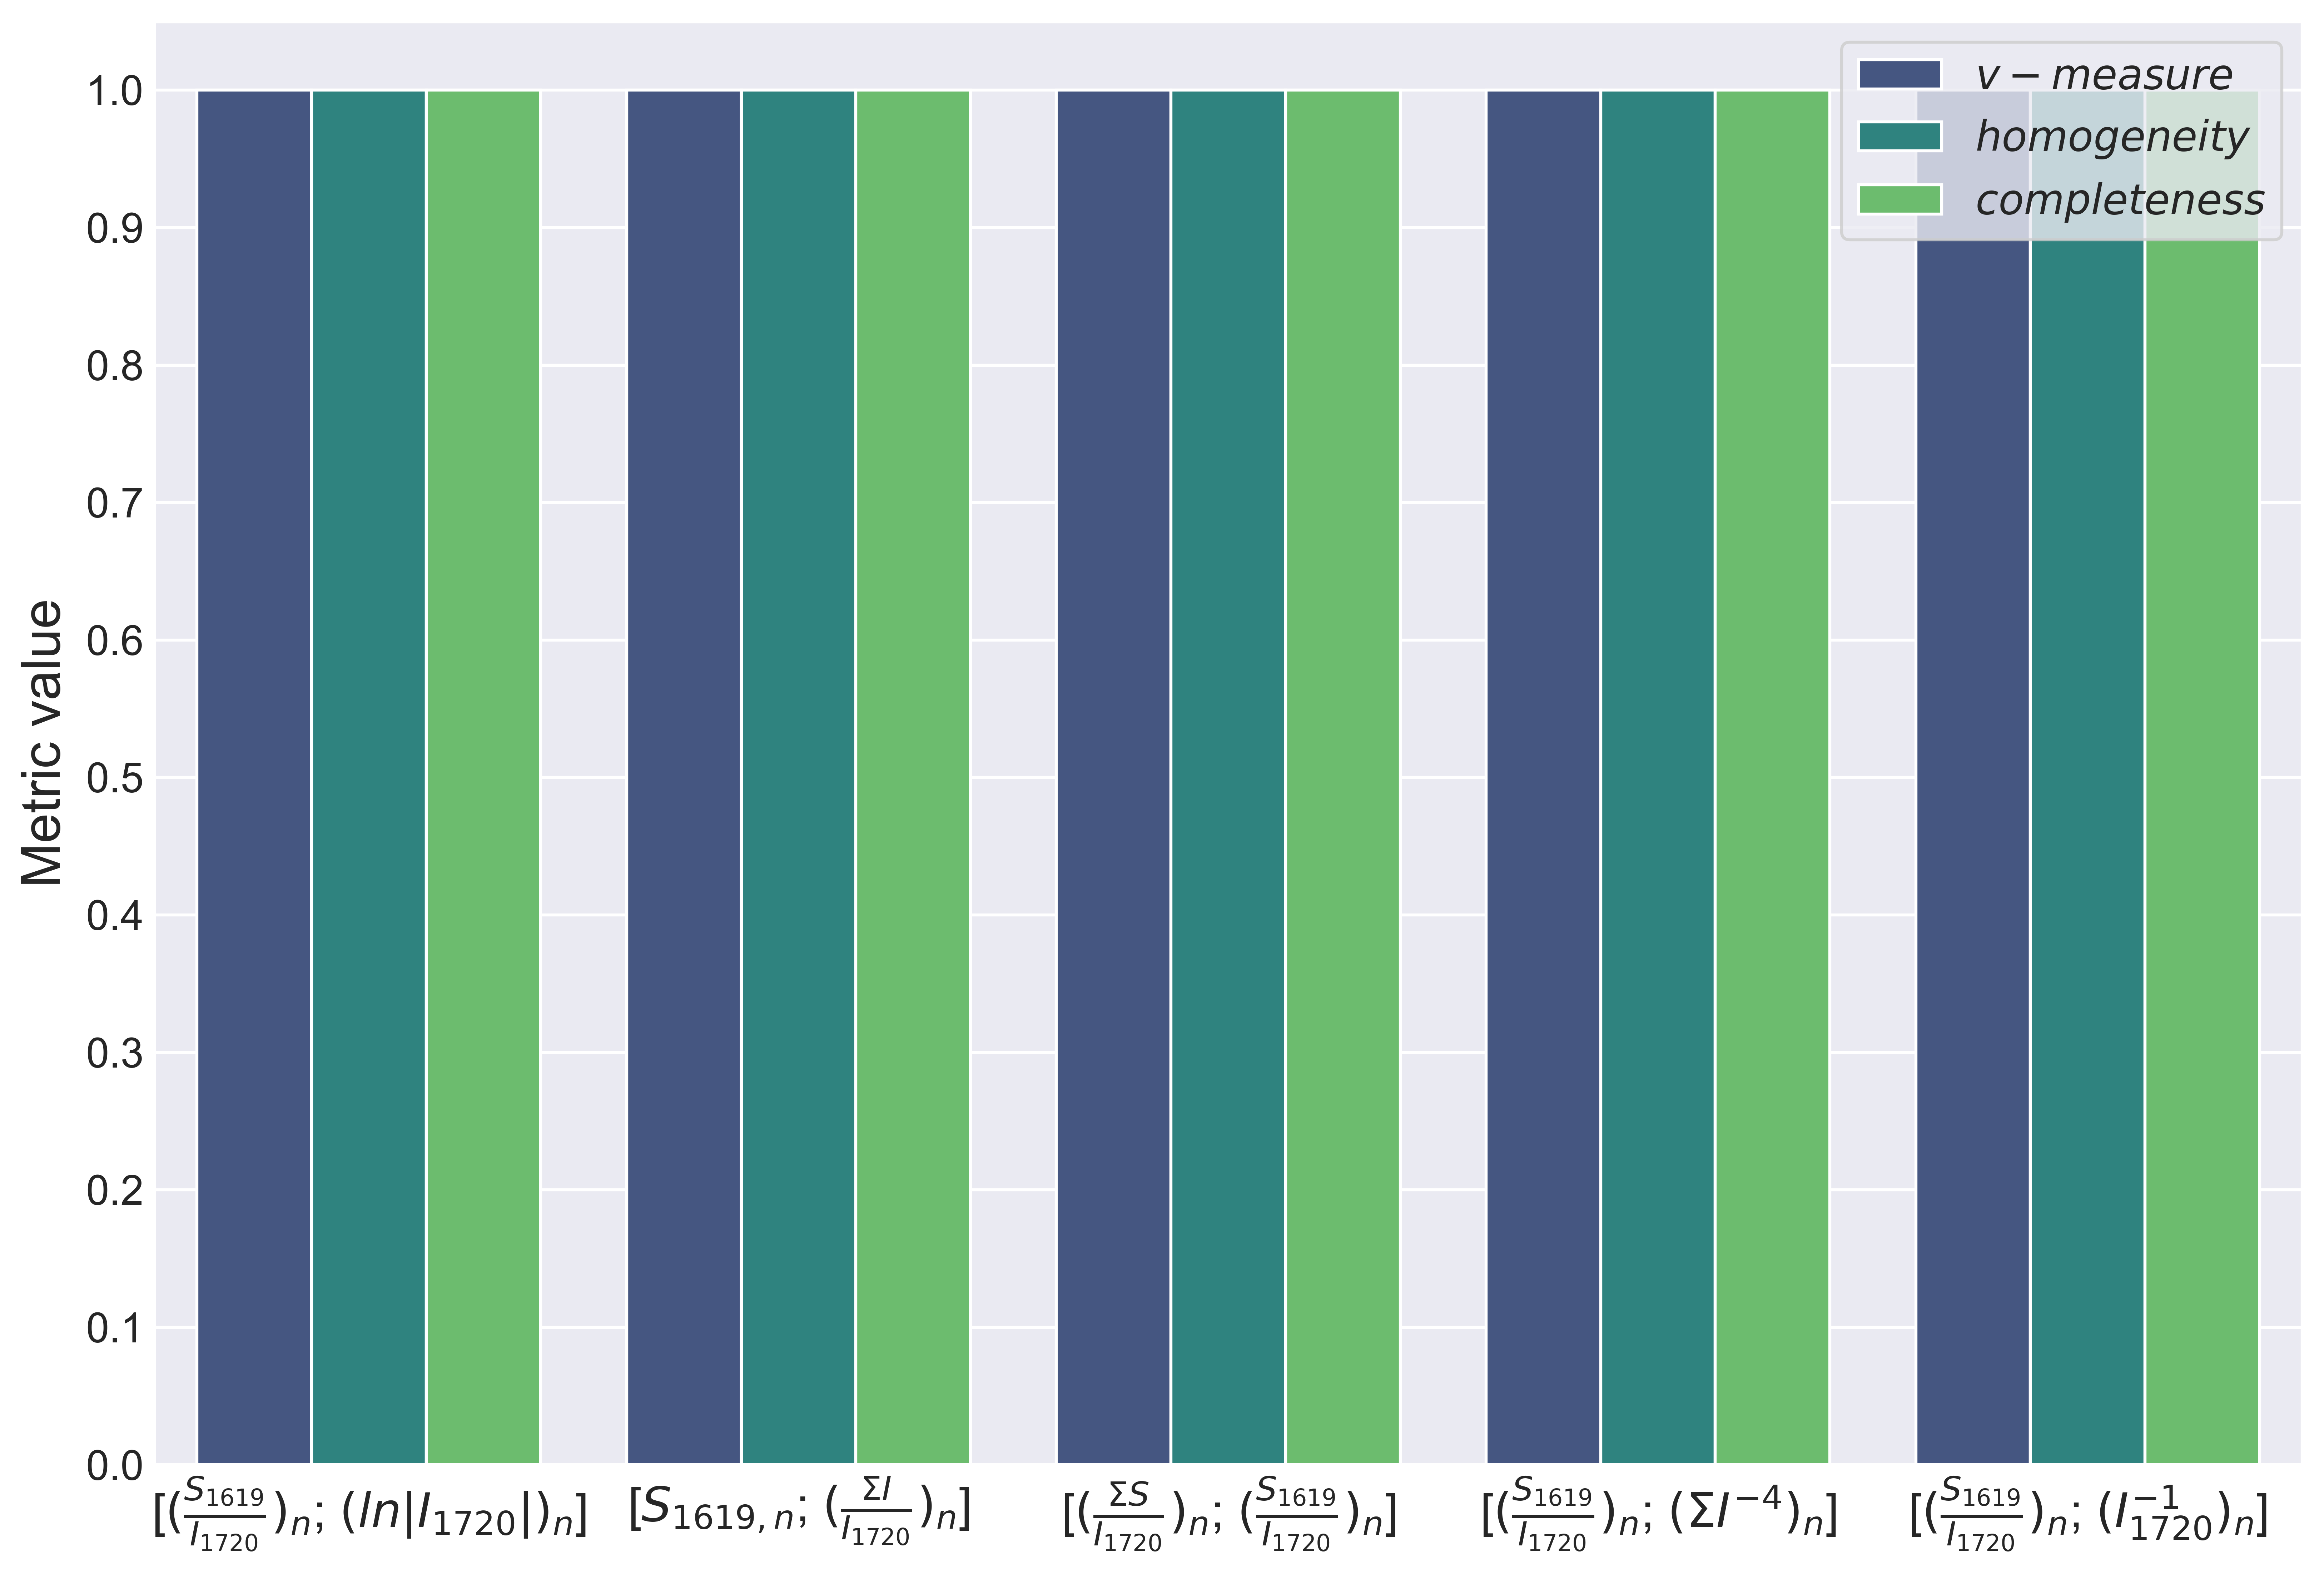

In [17]:
sns.set_theme()

fontsize = 18

fig, ax = plt.subplots(figsize=(11, 7.5), dpi=600)

ax.grid(True)
ax.tick_params(direction='in')

palette_choice = 'viridis'  # 'Set2', 'Dark2', 'muted', 'viridis'

bar = sns.barplot(
    data=qm_df_vis_top,
    x='Feature_Pair',
    y='Value',
    hue='Metric',
    palette=palette_choice,
    ax=ax
)

ax.set_xlabel('')

ax.set_ylabel(
    'Metric value',
    fontstyle='normal',
    fontsize=fontsize,
    rotation=90,
    labelpad=5
)

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

bar.set_xticklabels(bar.get_xticklabels(), rotation=0, ha="center", fontsize=fontsize-2)
bar.set_yticklabels(bar.get_yticklabels(), rotation=0, ha="right", fontsize=fontsize-4)

ax.legend_.set_title(None)
ax.legend(fontsize=fontsize-4)

plt.tight_layout()

plt.savefig(path_to_save + '/qm_barplot.png', dpi=600)
plt.show()

### Scatter plot in the coodirnares of *top-(1-3)* feature pairs

In [18]:
target = samples_description['Class']
hue = samples_description['Type']

type_color_dict = {
    '$GO$': 'RoyalBlue',
    '$rGO$': 'Goldenrod',
    '$GO_{d}$': 'SeaGreen'
}

In [19]:
target = samples_description['Class']
hue = samples_description['Type']

type_color_dict = {
    '$GO$': 'RoyalBlue',
    '$rGO$': 'Goldenrod',
    '$GO_{d}$': 'SeaGreen'
}

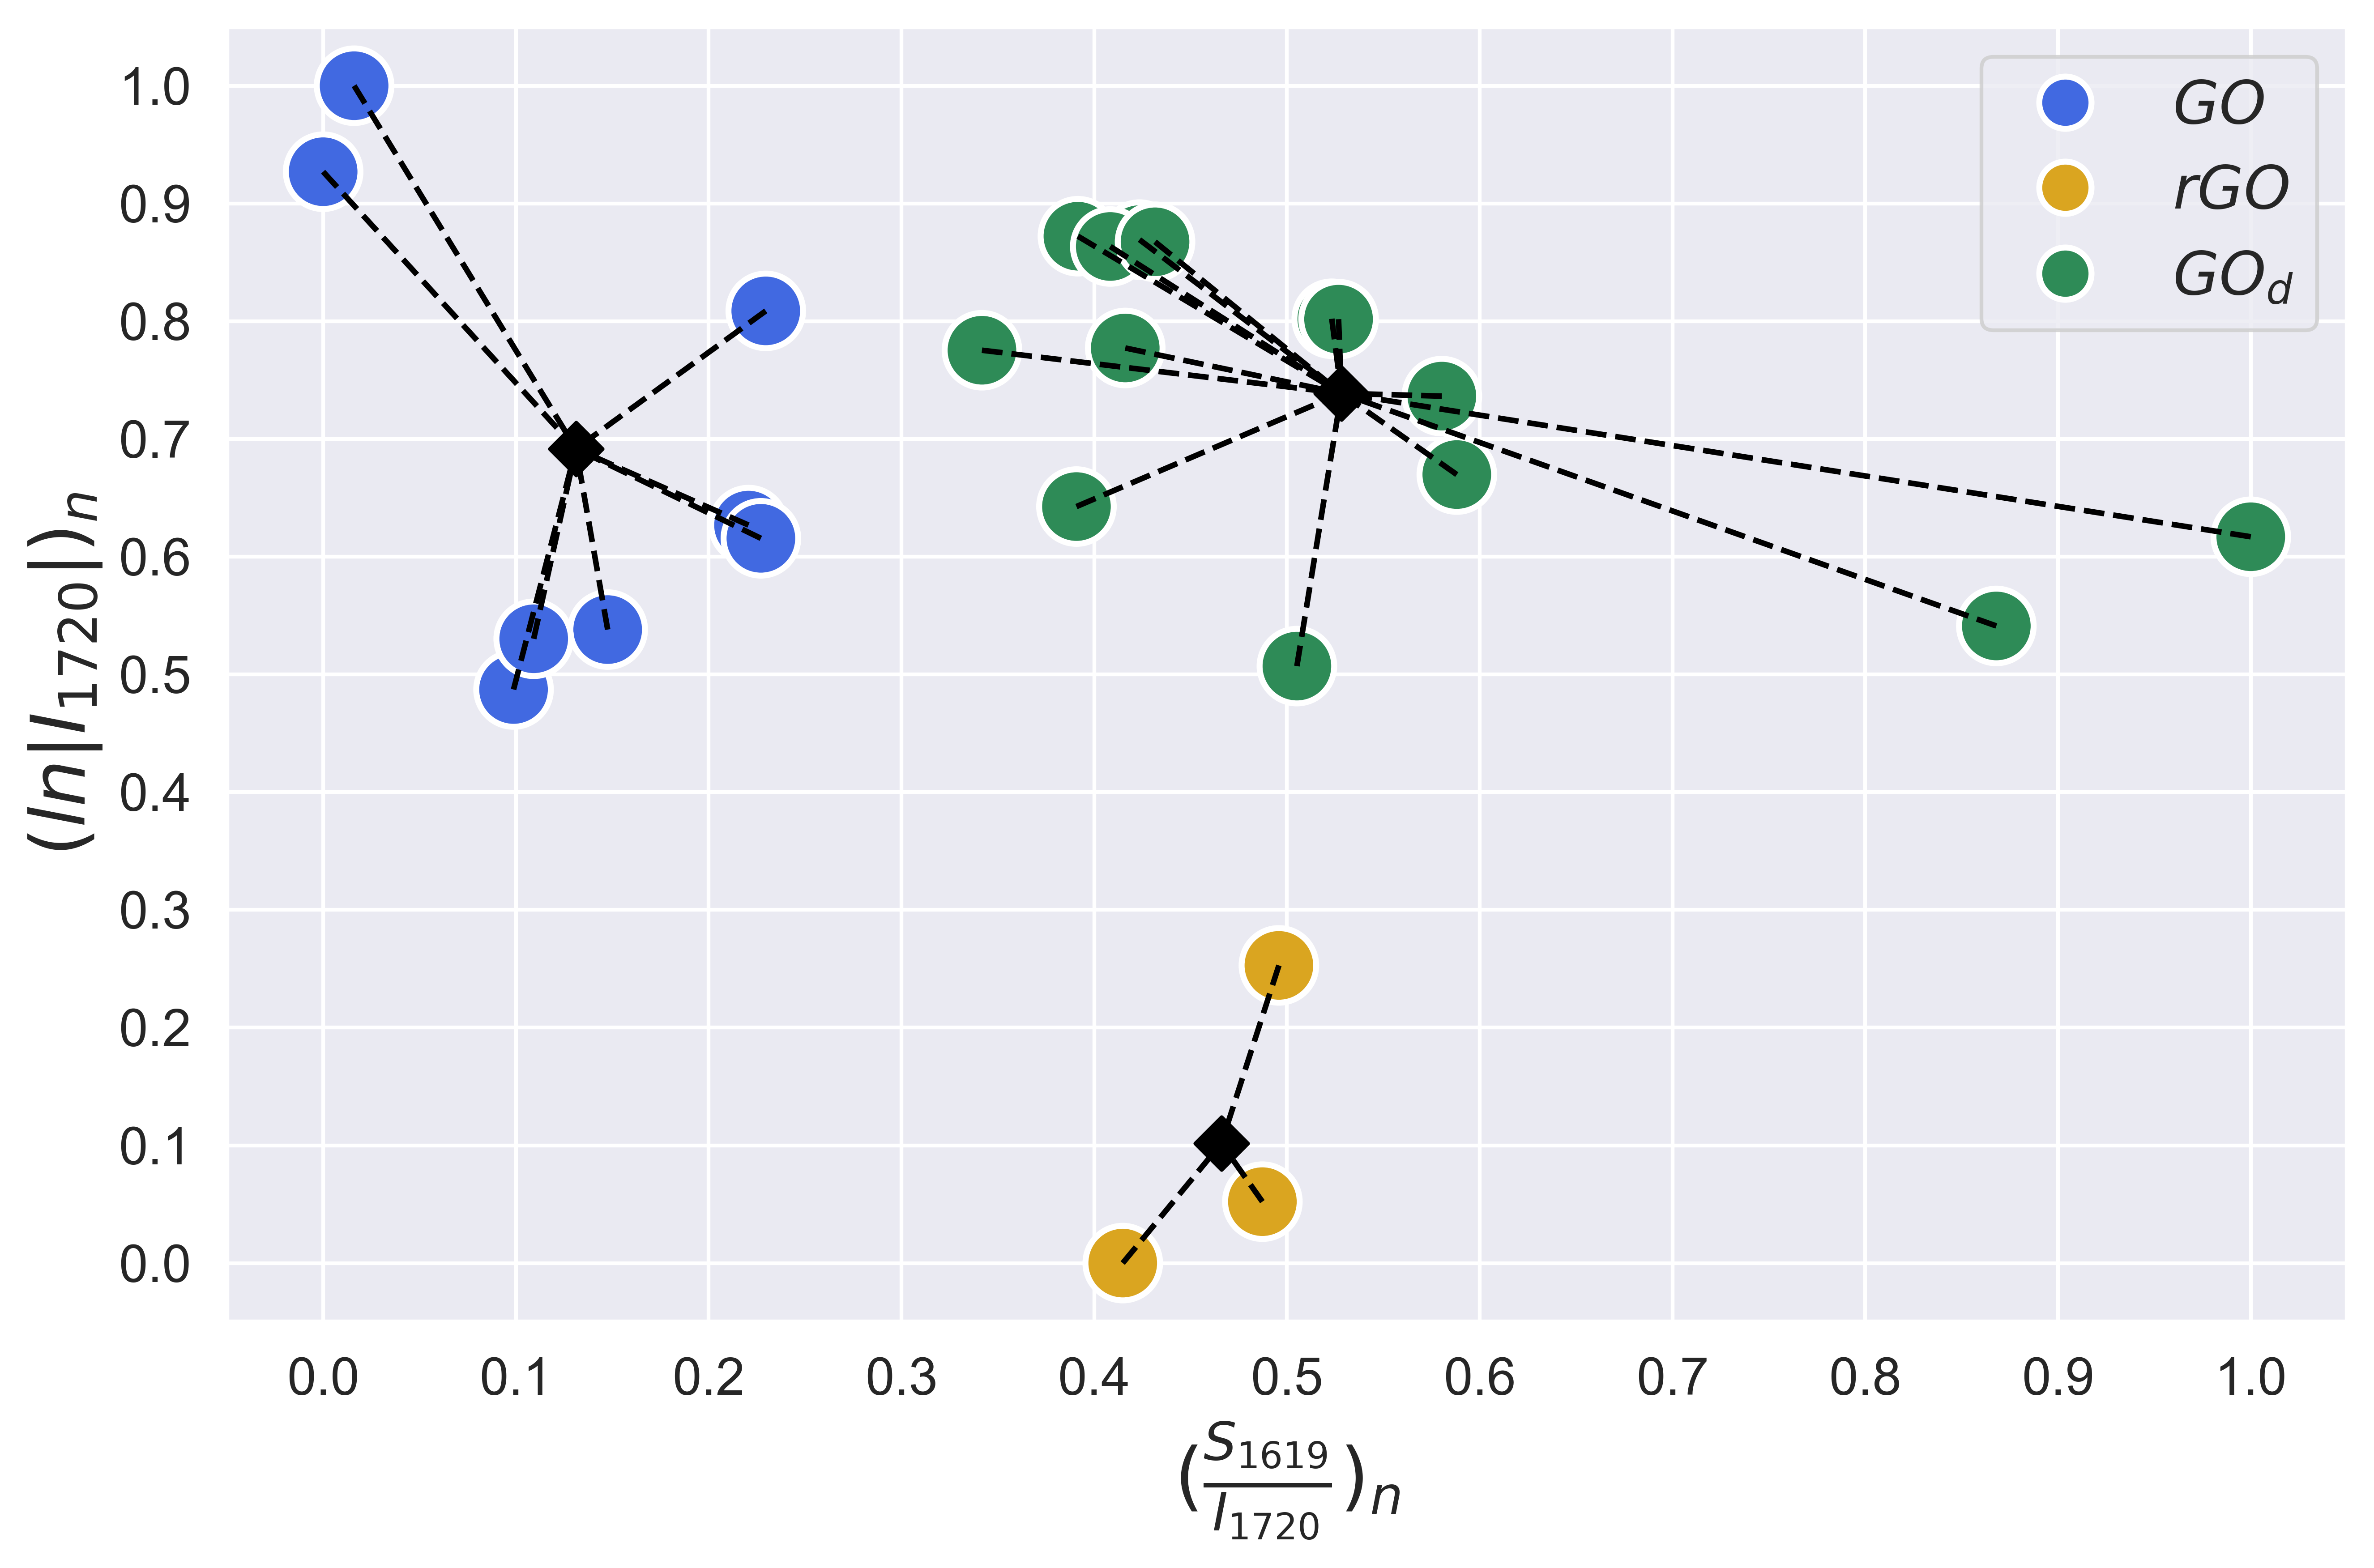

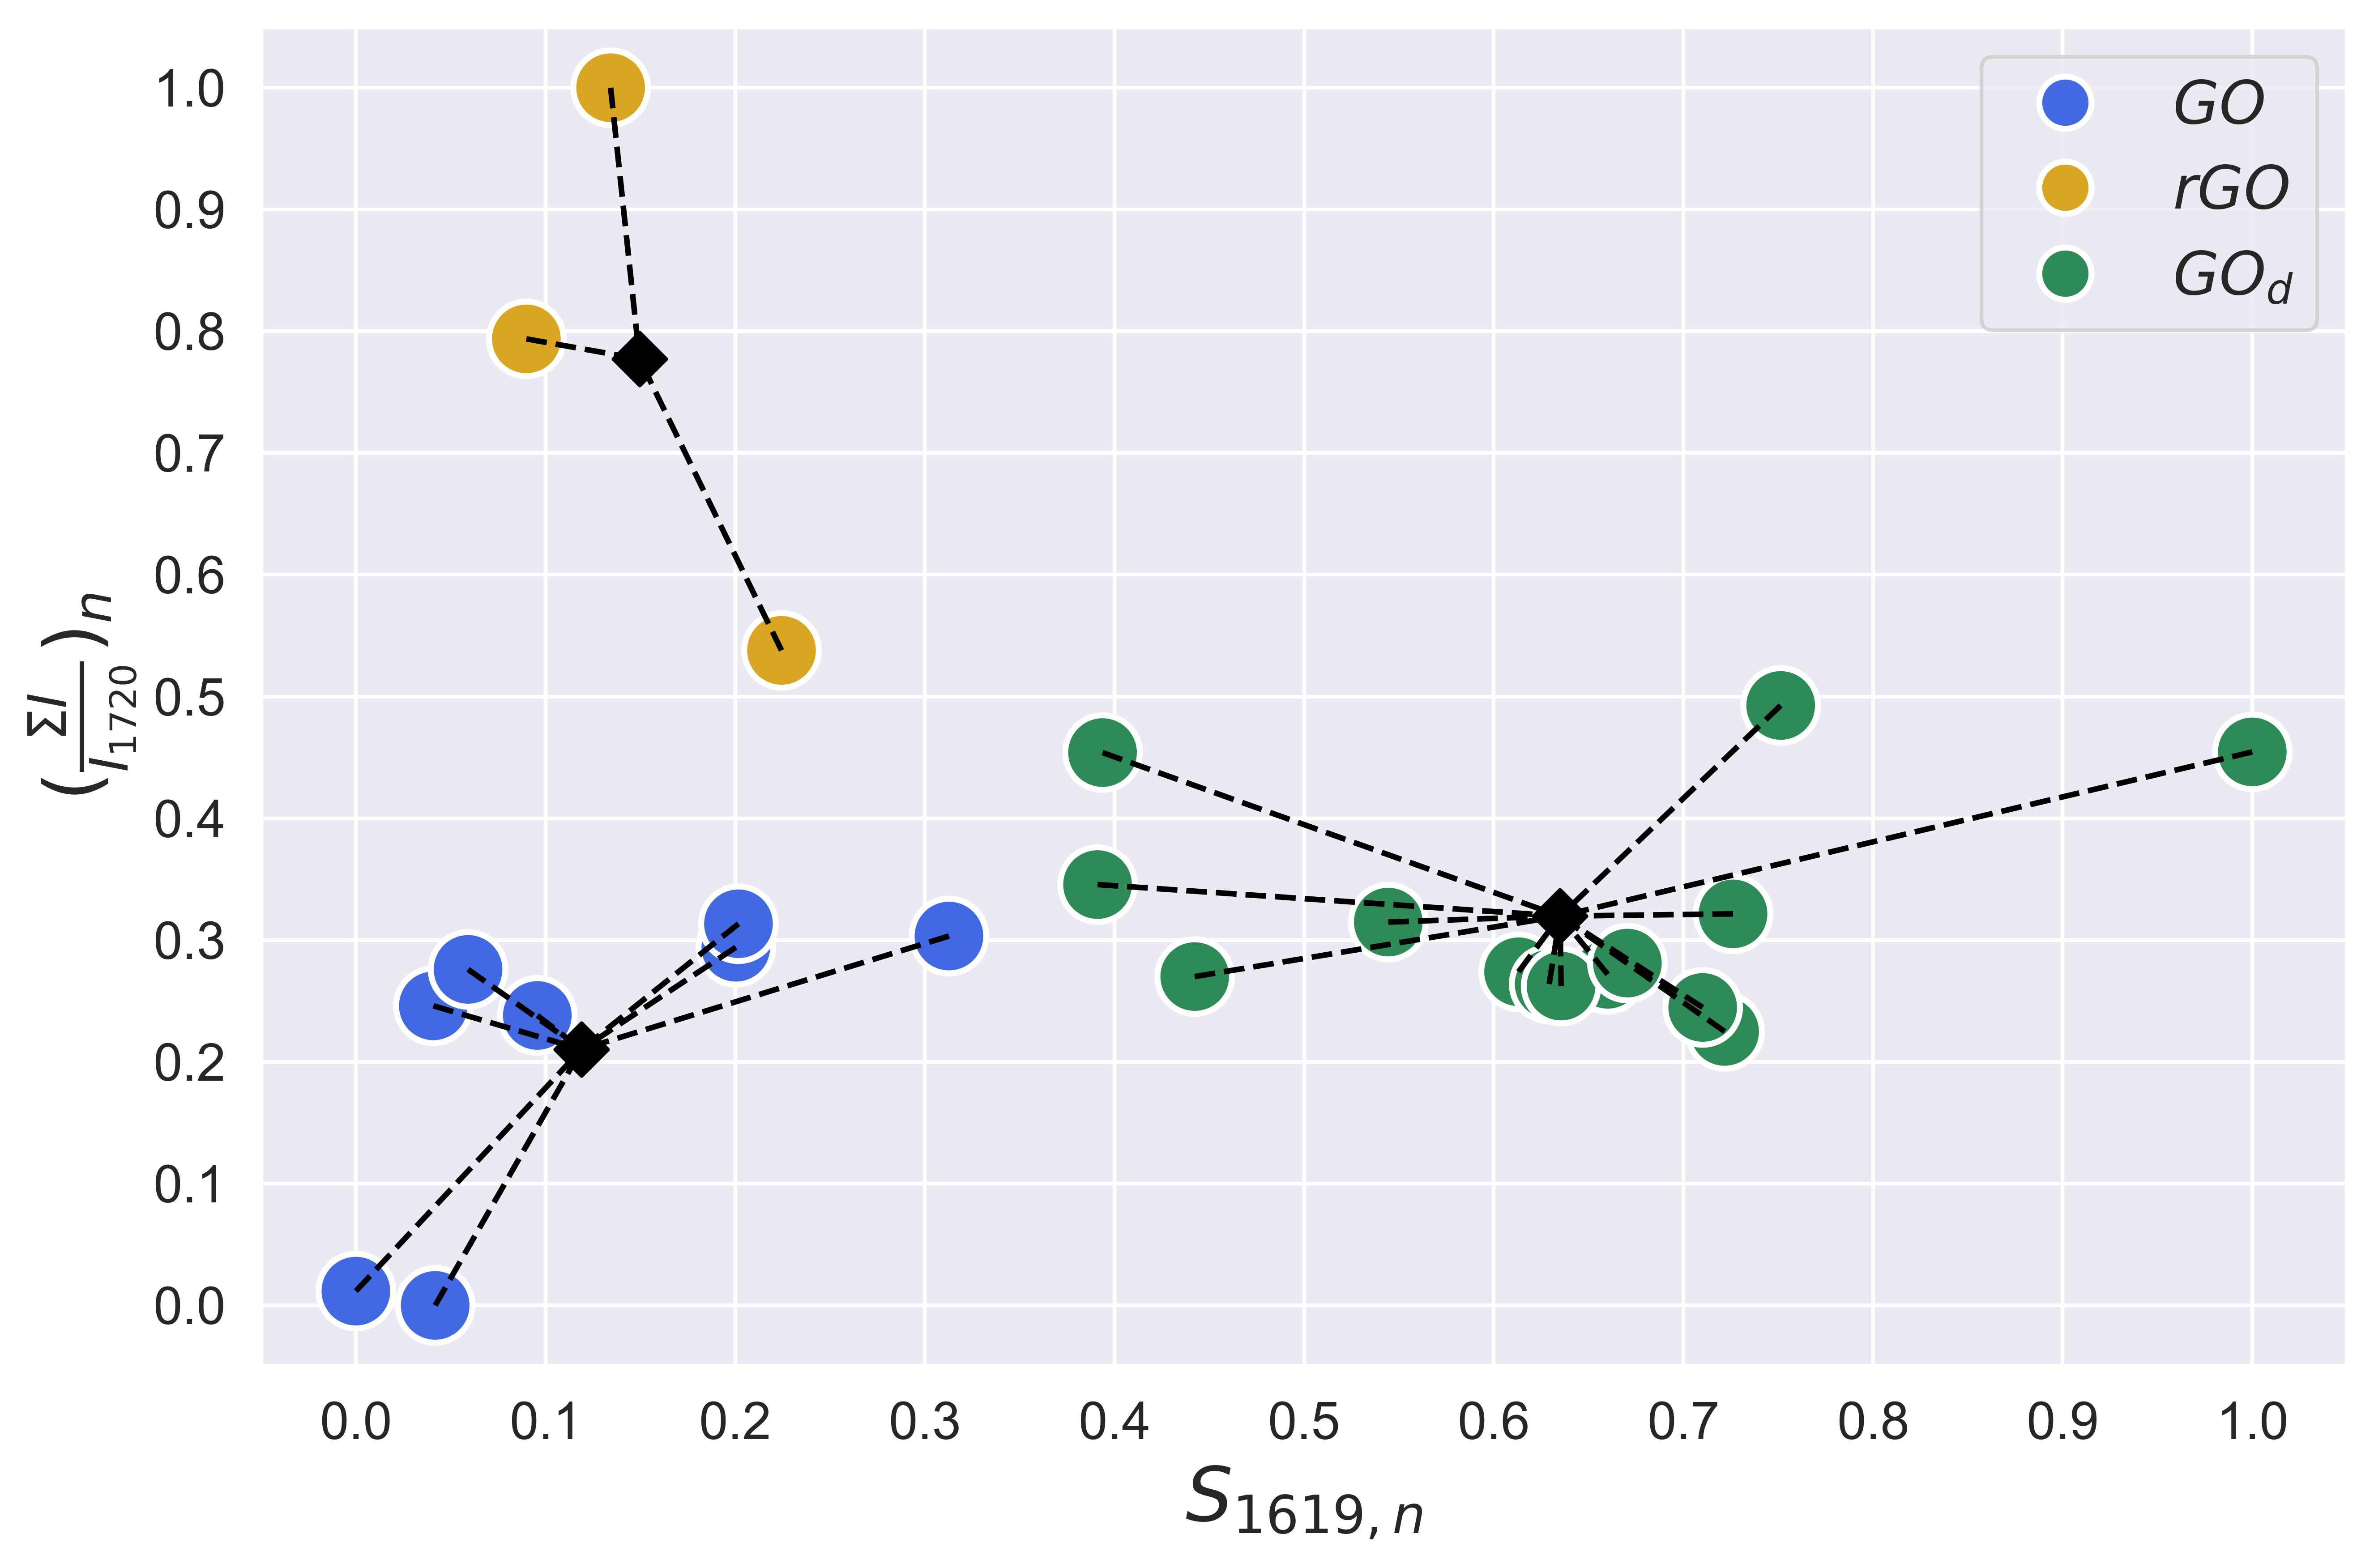

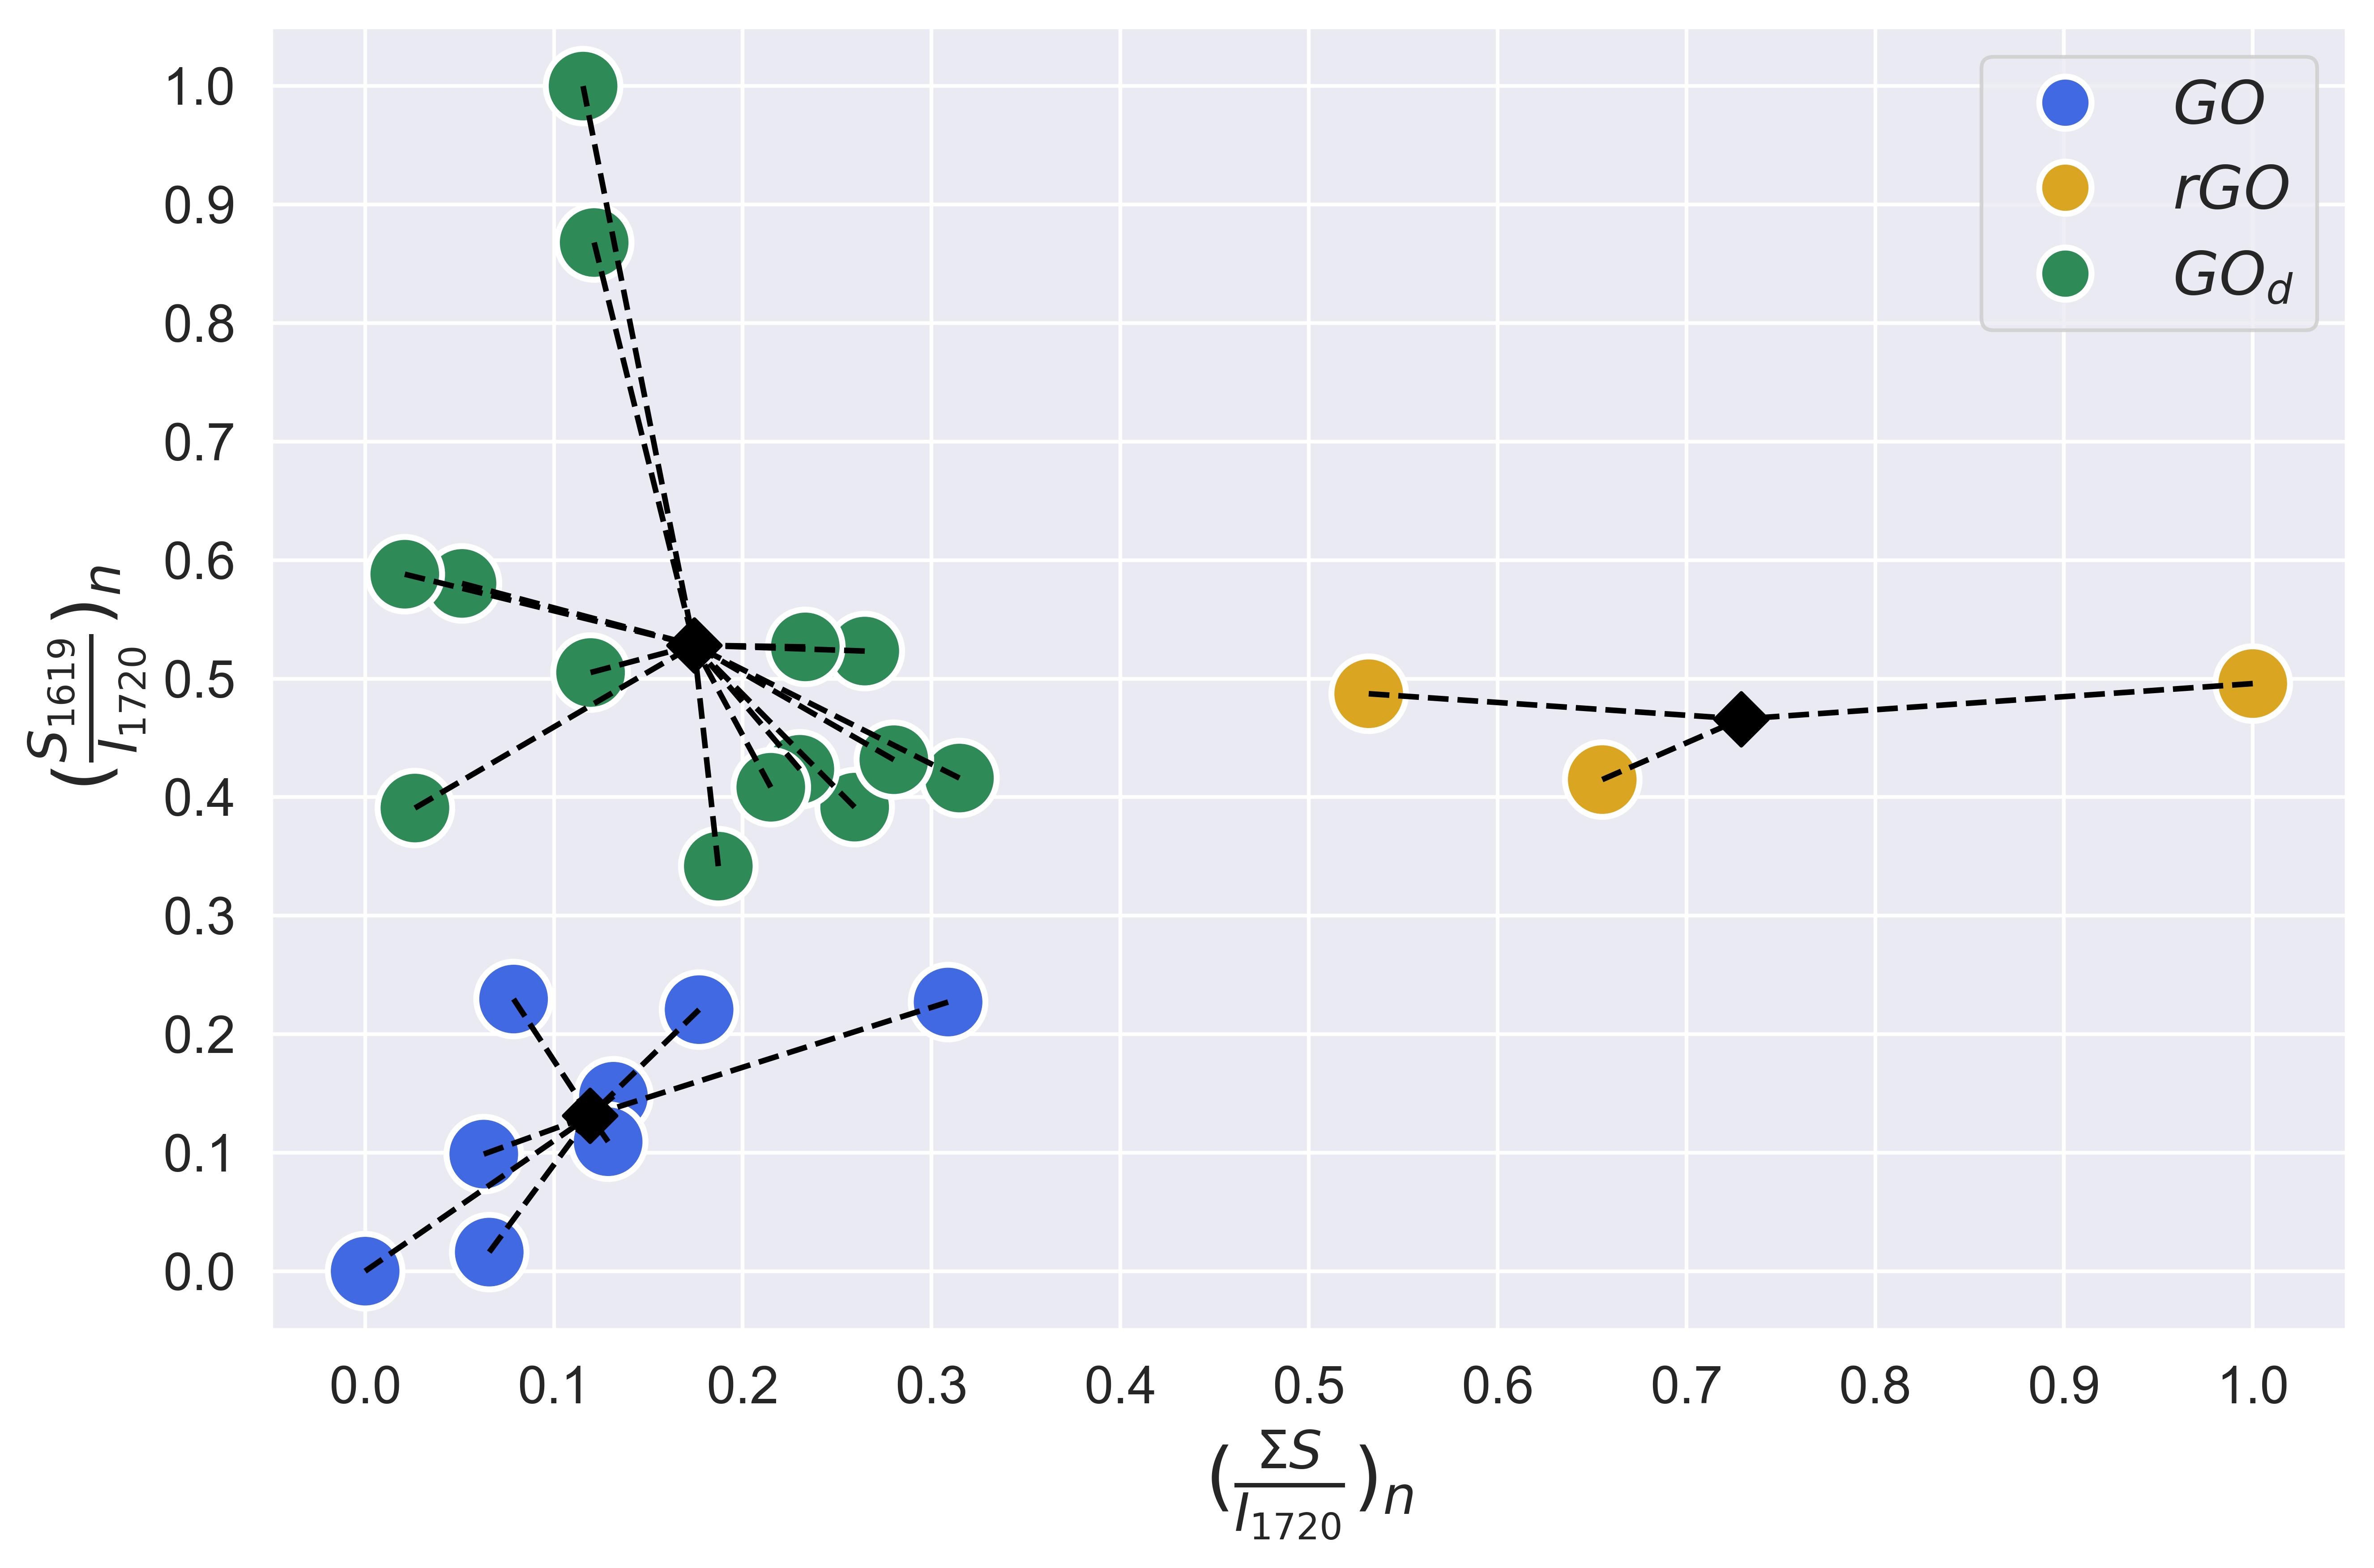

In [20]:
top_n = 3 

for i in range(top_n):
    feature_1, feature_2 = qm_df_vis_top['Feature_1'].tolist()[i], qm_df_vis_top['Feature_2'].tolist()[i]
    
    top_features_pair_df = engineered_data.loc[:, [feature_1, feature_2]]
    
    analyzer = ClusterAnalysis2D(target=target, hue=hue)
    
    opt_n_cluster = analyzer.optimize_n_clusters(train_data=top_features_pair_df, metric='v_measure')
    
    analyzer.fit_transform_kmeans(train_data=top_features_pair_df, n_clusters=opt_n_cluster)

    if i == 0:
        full_path_to_save = path_to_save + f'/scatterplot_top{i+1}.png'
    else:
        full_path_to_save = None

    analyzer.get_clustering_visualization(
        figsize=(9, 6.0),
        markersize=400,
        palette=type_color_dict,
        color=None,
        fontsize=20,
        print_point_labels=False,
        filter_class=None,
        path_to_save=full_path_to_save,
        dpi=600
    )

### Detailed analysis — scatterplot in the coodirnares of *top-1* features pair grouped by sample type

In [21]:
classes_lst = samples_description['Class'].unique()

class_color_dict = {
    0: 'Goldenrod',
    1: 'RoyalBlue',
    2: 'SeaGreen'
}

In [22]:
feature_1, feature_2 = qm_df_vis_top['Feature_1'].tolist()[0], qm_df_vis_top['Feature_2'].tolist()[0]

top_features_pair_df = engineered_data.loc[:, [feature_1, feature_2]]

print(top_features_pair_df.shape)
top_features_pair_df.head(3)

(25, 2)


$(\frac{S_{1619}}{I_{1720}})_{n}$  $(ln|I_{1720}|)_{n}$
1                           0.016069              1.000000
2                           0.229625              0.808758
3                           0.220679              0.626817

In [23]:
analyzer = ClusterAnalysis2D(target=target, hue=hue)
opt_n_cluster = analyzer.optimize_n_clusters(train_data=top_features_pair_df, metric='v_measure')
analyzer.fit_transform_kmeans(train_data=top_features_pair_df, n_clusters=opt_n_cluster)

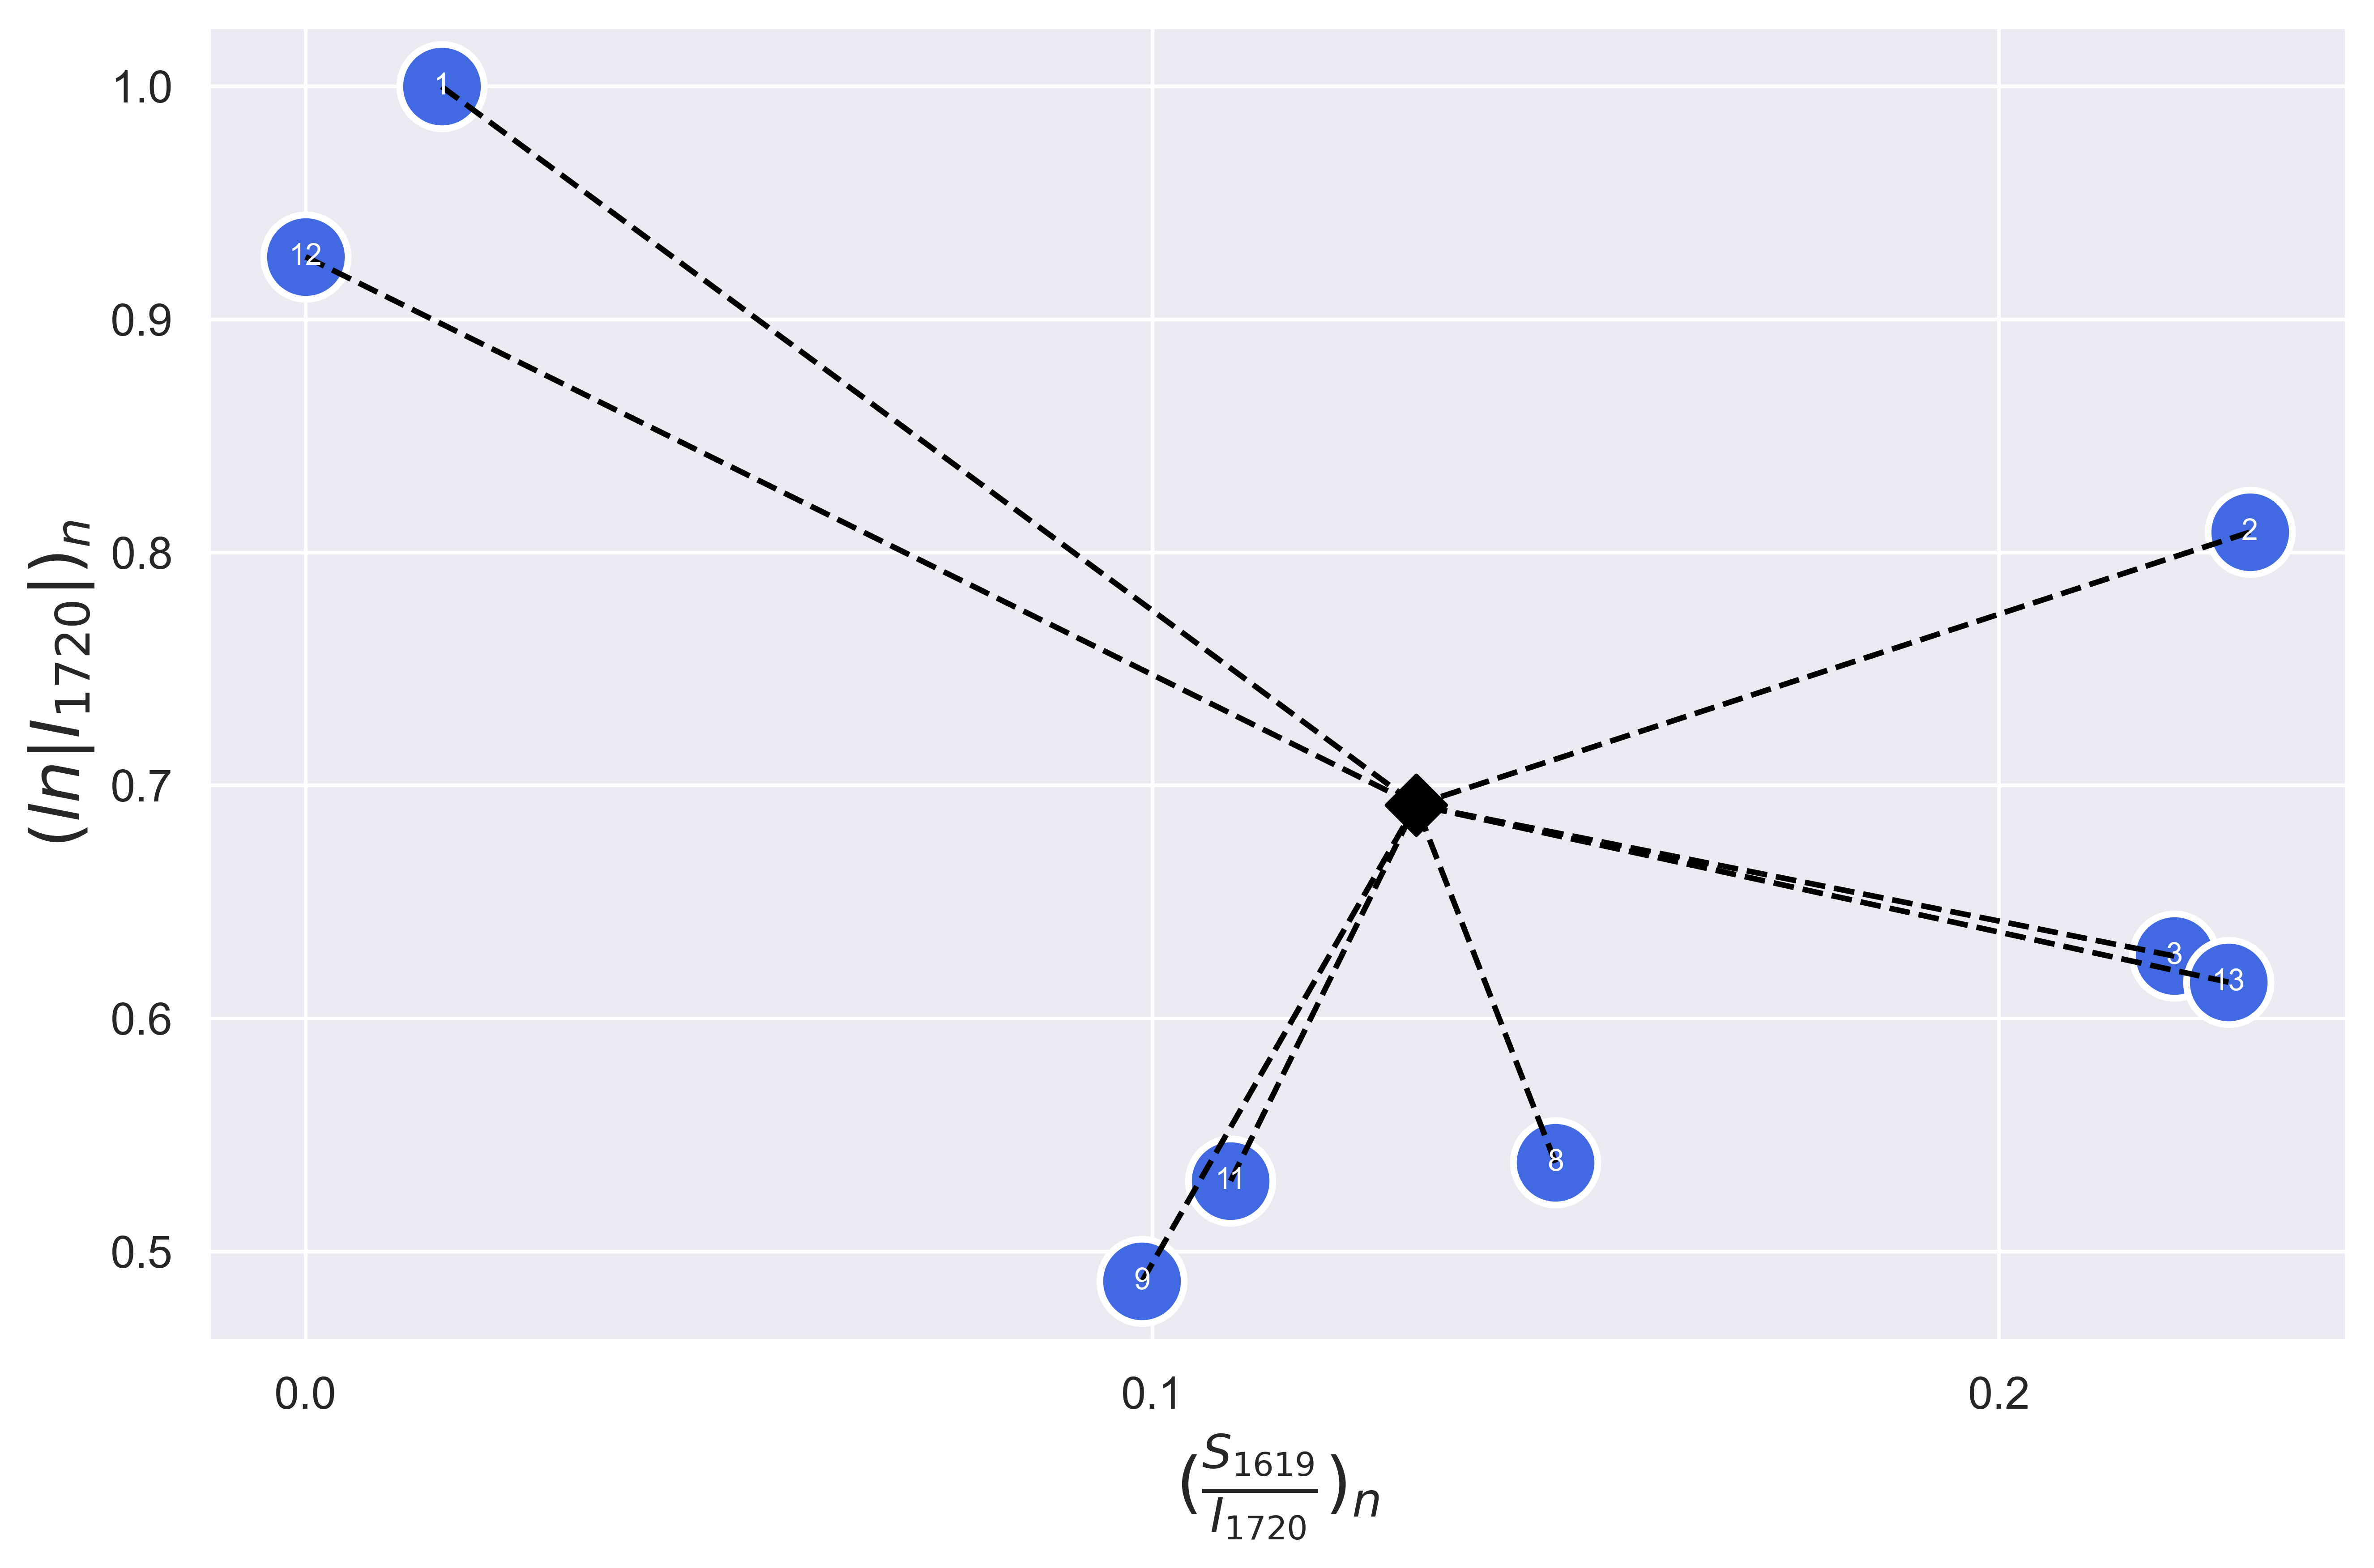

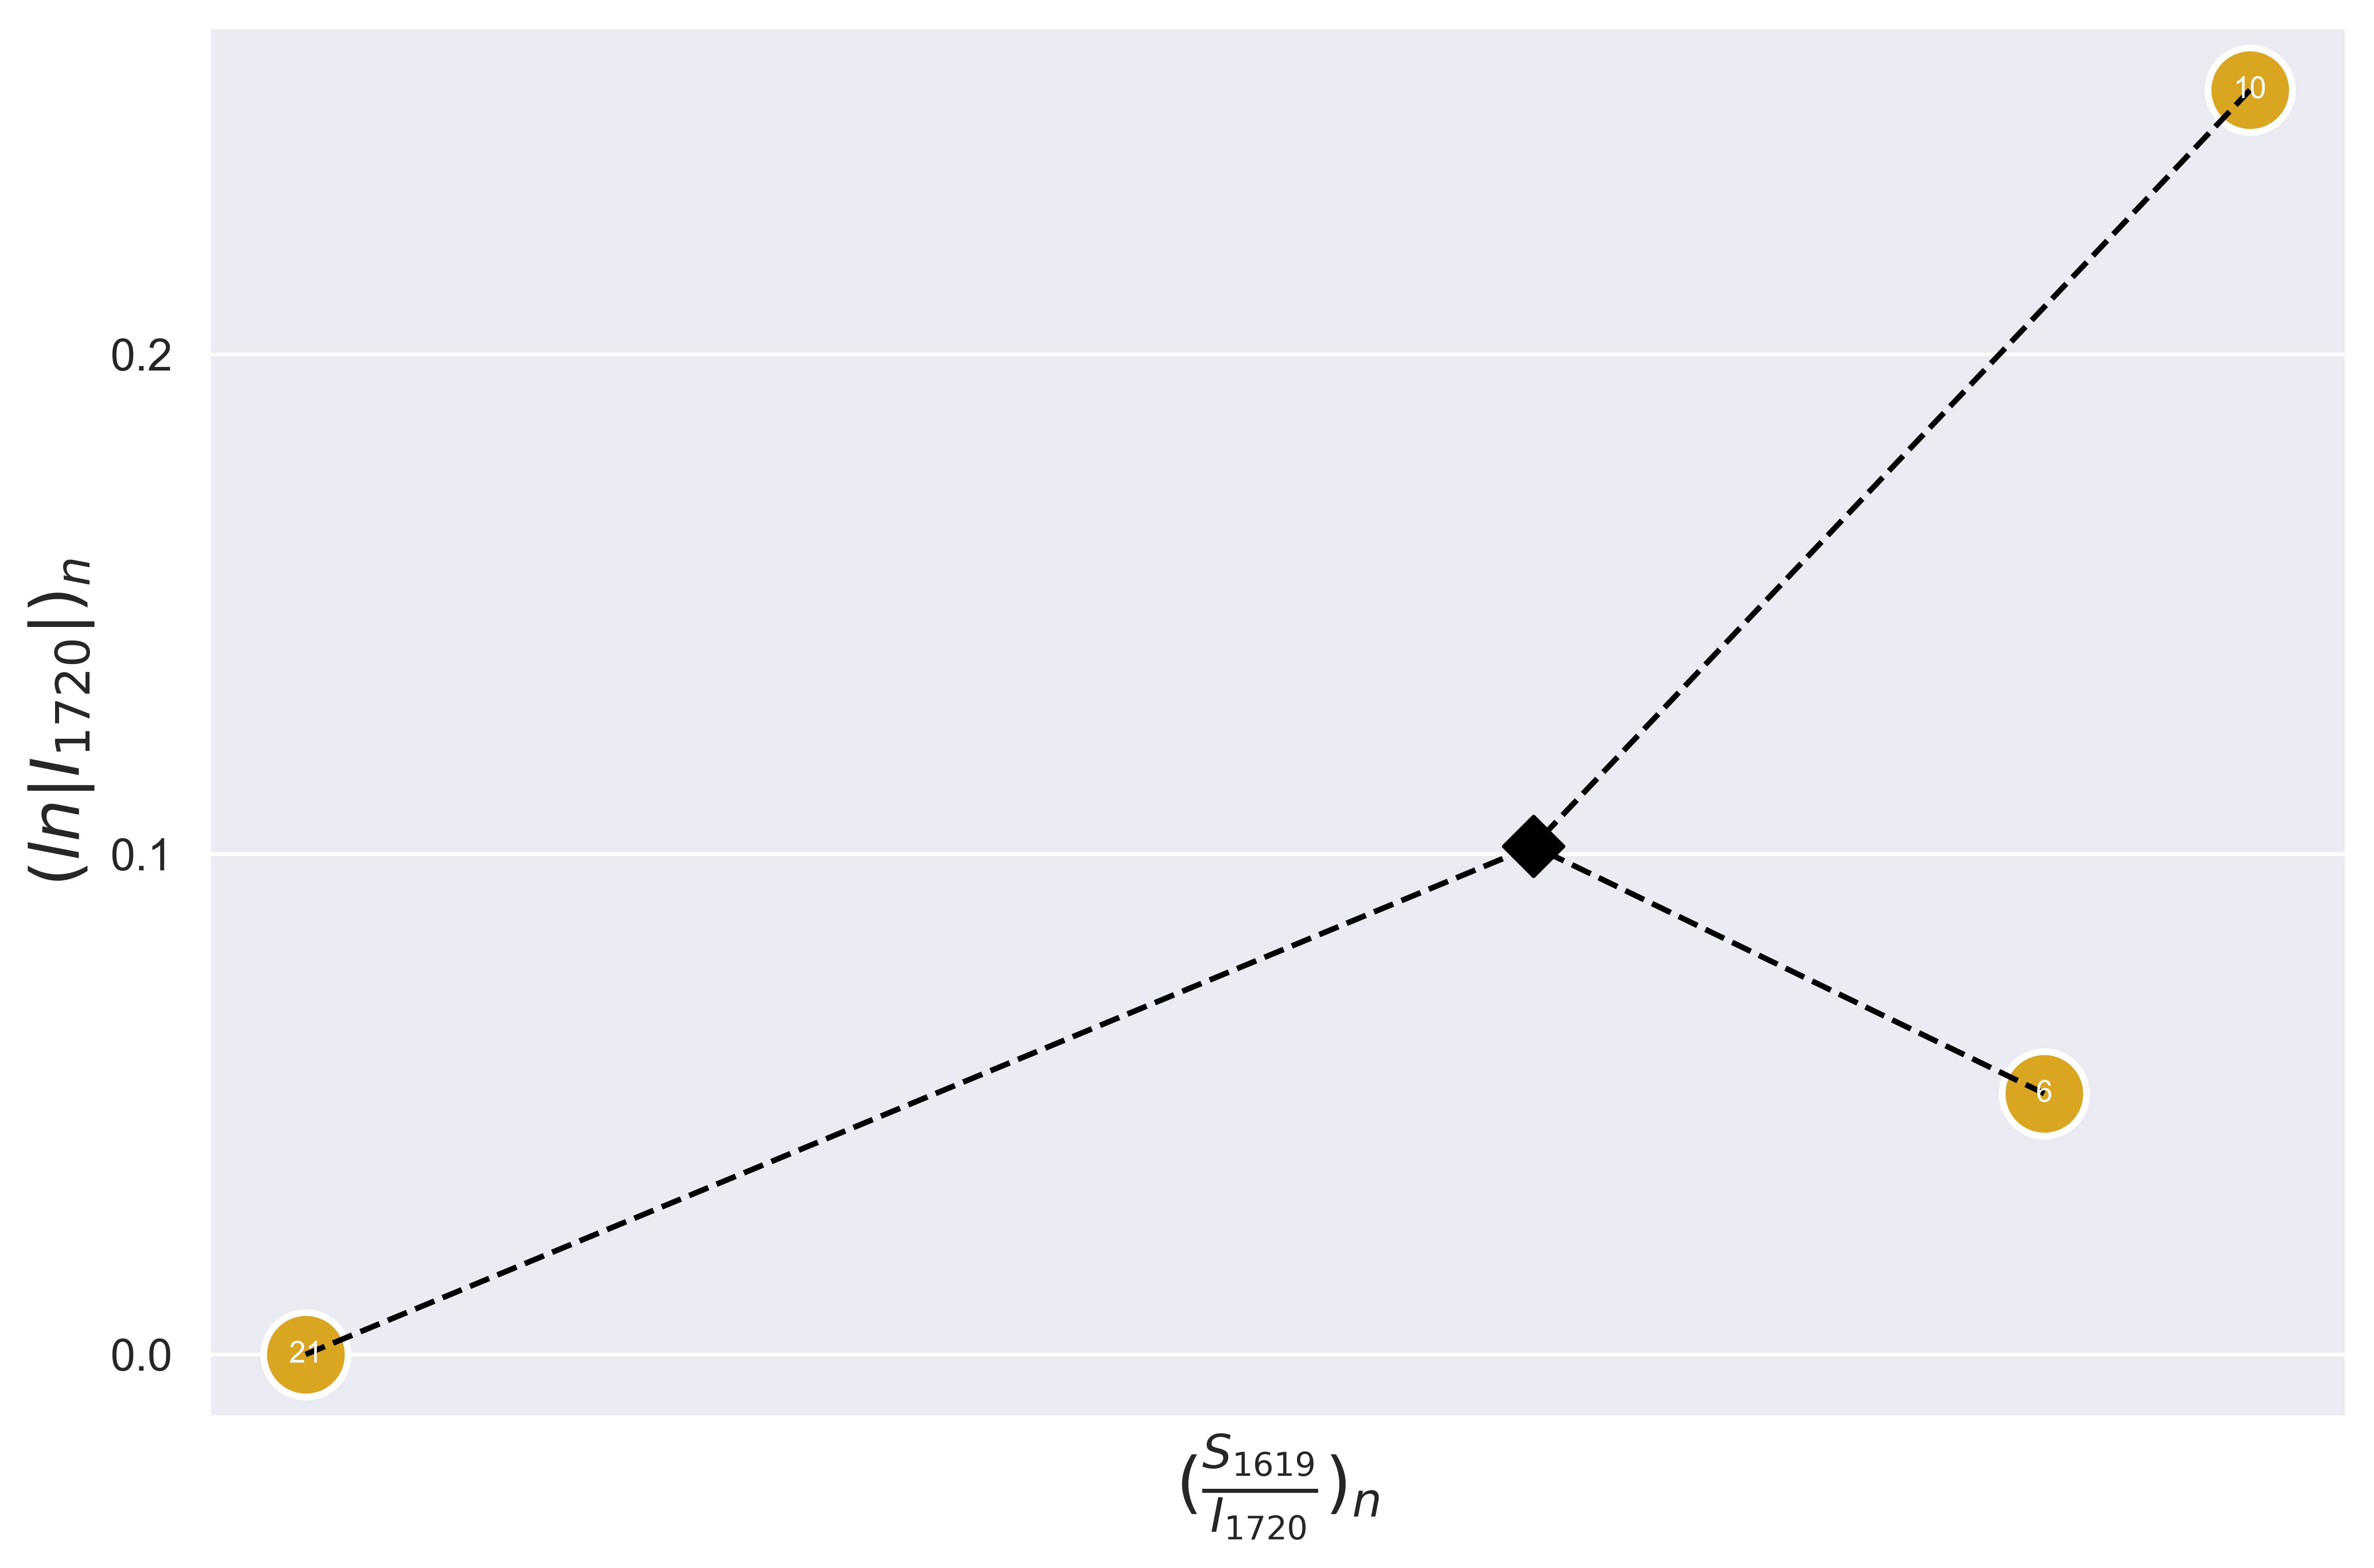

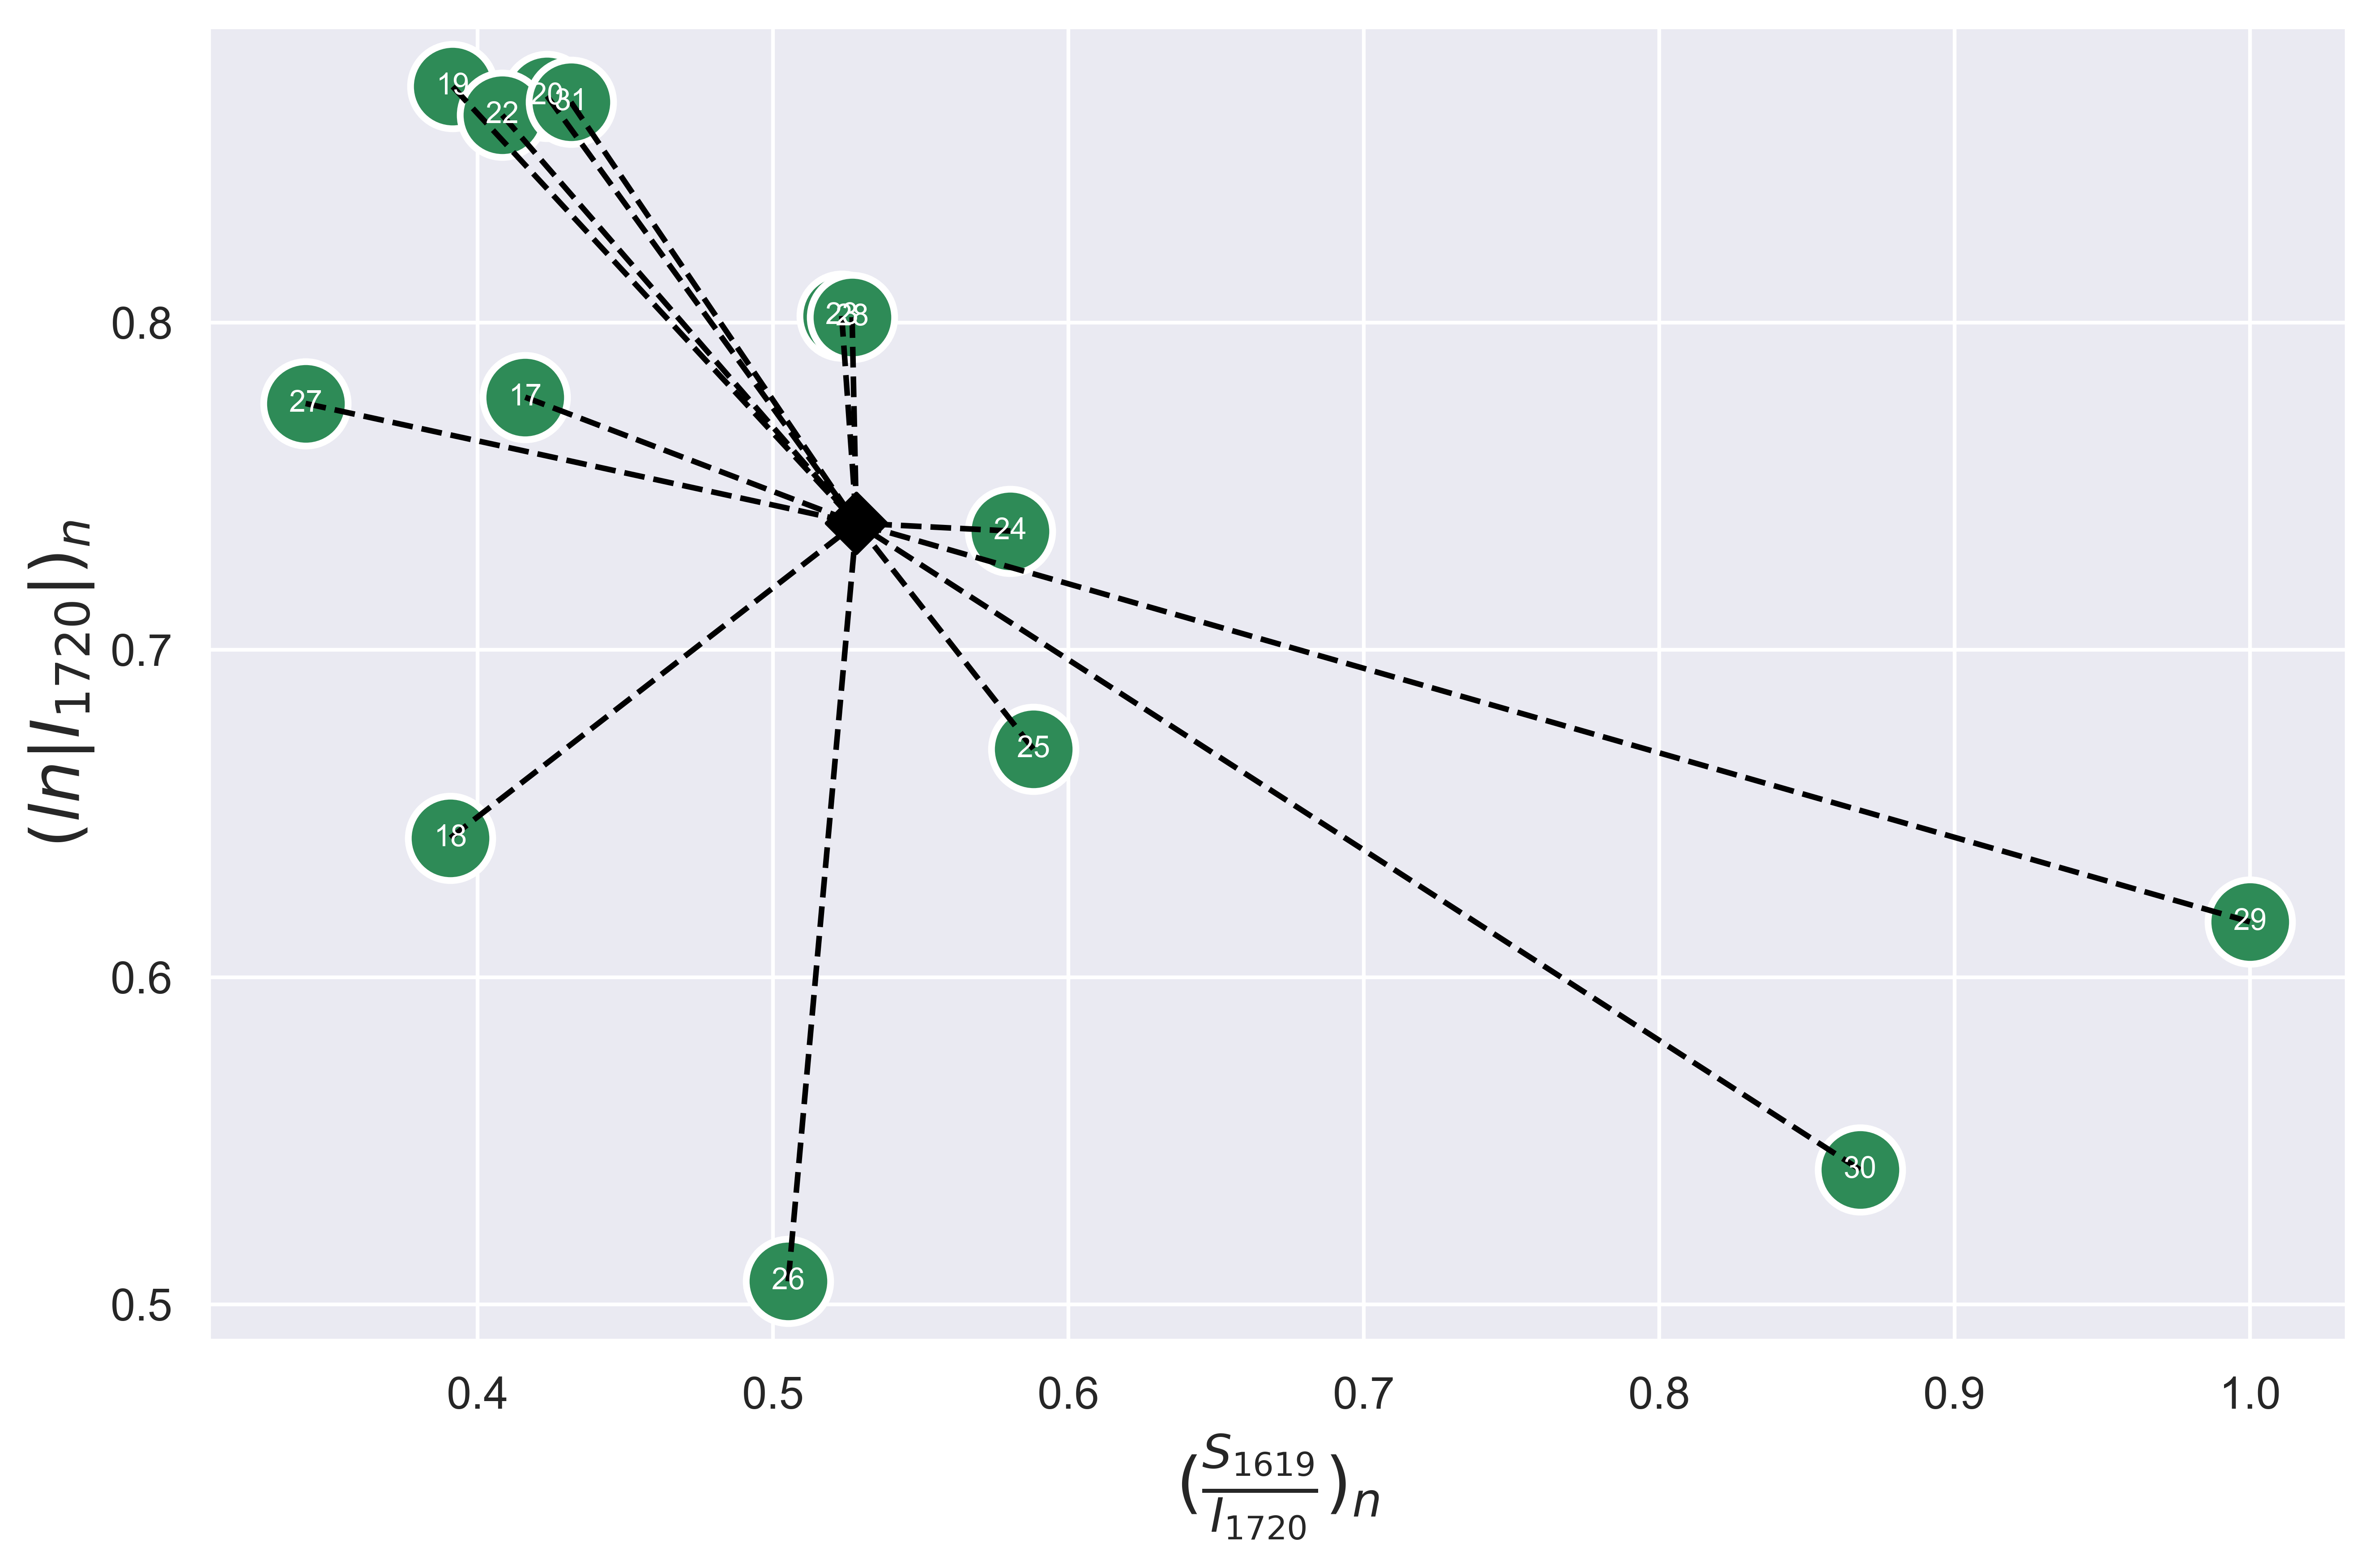

In [24]:
for i, class_ in enumerate(classes_lst):
    
    analyzer.get_clustering_visualization(
        figsize=(9.0, 6.0),
        markersize=512,
        fontsize=18,
        palette=None,
        color=class_color_dict[class_],
        print_point_labels=True,
        filter_class=class_,
        path_to_save=f'{path_to_save}/',
        dpi=600
    )

### Collecting images for *graphical abstract*

#### *QM* bar plot

In [25]:
path_to_graphical_abstract = './../../../../smth_else/graphical_abstract'

In [26]:
feature_pairs =[
    '[$(\\frac{S_{1619}}{I_{1720}})_{n}$; $(ln|I_{1720}|)_{n}$]',
    '[$S_{1619, n}$; $(\\frac{ΣI}{I_{1720}})_{n}$]',
    '[$(\\frac{ΣS}{I_{1720}})_{n}$; $(\\frac{S_{1619}}{I_{1720}})_{n}$]'
]

barplot_data = qm_df_vis_top.loc[qm_df_vis_top['Feature_Pair'].isin(feature_pairs)]

print(barplot_data.shape)
barplot_data.head(3)

(9, 5)


Feature_1                          Feature_2  \
7827  $(\frac{S_{1619}}{I_{1720}})_{n}$               $(ln|I_{1720}|)_{n}$   
6722                      $S_{1619, n}$        $(\frac{ΣI}{I_{1720}})_{n}$   
7446        $(\frac{ΣS}{I_{1720}})_{n}$  $(\frac{S_{1619}}{I_{1720}})_{n}$   

                                           Feature_Pair       Metric  Value  
7827  [$(\frac{S_{1619}}{I_{1720}})_{n}$; $(ln|I_{17...  $v-measure$    1.0  
6722       [$S_{1619, n}$; $(\frac{ΣI}{I_{1720}})_{n}$]  $v-measure$    1.0  
7446  [$(\frac{ΣS}{I_{1720}})_{n}$; $(\frac{S_{1619}...  $v-measure$    1.0

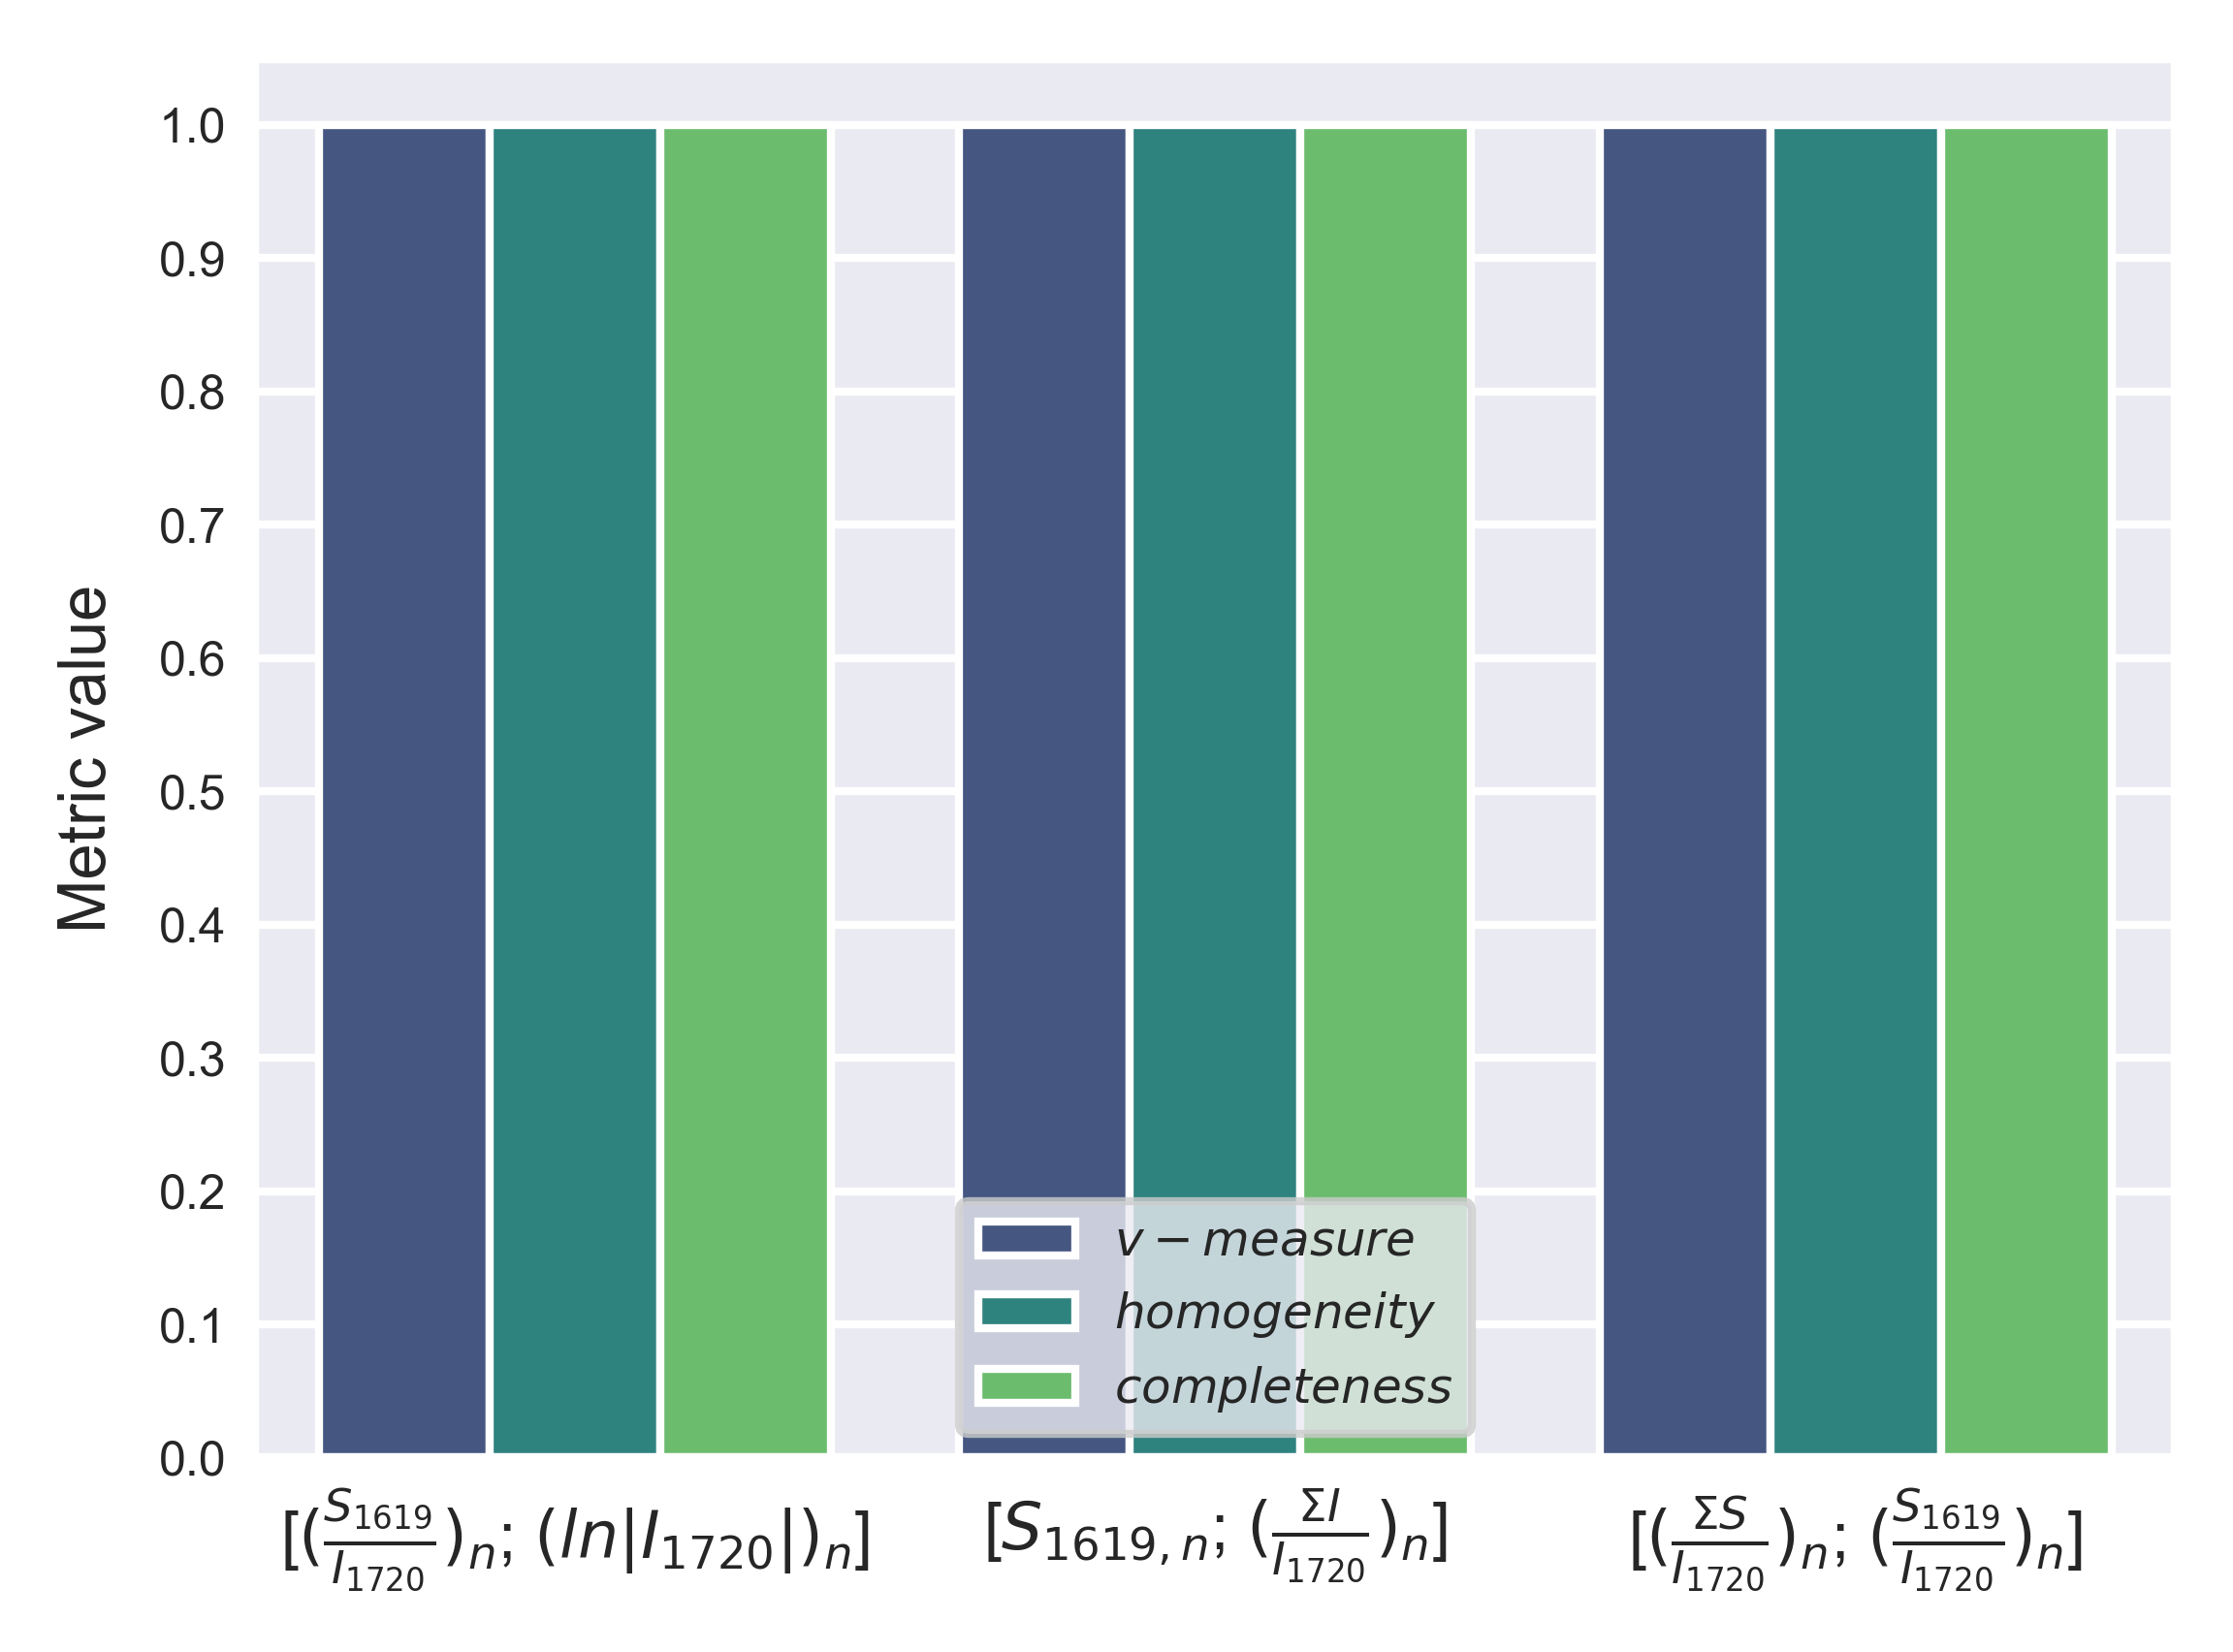

In [27]:
sns.set_theme()

fontsize = 8

fig, ax = plt.subplots(figsize=(4, 3), dpi=600)

ax.grid(True)
ax.tick_params(direction='in')

palette_choice = 'viridis'  # 'Set2', 'Dark2', 'muted', 'viridis'

bar = sns.barplot(
    data=barplot_data,
    x='Feature_Pair',
    y='Value',
    hue='Metric',
    palette=palette_choice,
    ax=ax
)

ax.set_xlabel('')

ax.set_ylabel(
    'Metric value',
    fontstyle='normal',
    fontsize=fontsize,
    rotation=90,
    labelpad=5
)

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

bar.set_xticklabels(bar.get_xticklabels(), rotation=0, ha="center", fontsize=fontsize)
bar.set_yticklabels(bar.get_yticklabels(), rotation=0, ha="right", fontsize=fontsize-2)

ax.legend_.set_title(None)
ax.legend(loc='lower center', fontsize=fontsize-2)

plt.tight_layout()

plt.savefig(f'{path_to_graphical_abstract}/qm_barplot_top3.png', dpi=600)
plt.show()

In [32]:
print(barplot_data)

                              Feature_1                          Feature_2  \
7827  $(\frac{S_{1619}}{I_{1720}})_{n}$               $(ln|I_{1720}|)_{n}$   
6722                      $S_{1619, n}$        $(\frac{ΣI}{I_{1720}})_{n}$   
7446        $(\frac{ΣS}{I_{1720}})_{n}$  $(\frac{S_{1619}}{I_{1720}})_{n}$   
242                       $S_{1619, n}$        $(\frac{ΣI}{I_{1720}})_{n}$   
966         $(\frac{ΣS}{I_{1720}})_{n}$  $(\frac{S_{1619}}{I_{1720}})_{n}$   
1347  $(\frac{S_{1619}}{I_{1720}})_{n}$               $(ln|I_{1720}|)_{n}$   
4587  $(\frac{S_{1619}}{I_{1720}})_{n}$               $(ln|I_{1720}|)_{n}$   
3482                      $S_{1619, n}$        $(\frac{ΣI}{I_{1720}})_{n}$   
4206        $(\frac{ΣS}{I_{1720}})_{n}$  $(\frac{S_{1619}}{I_{1720}})_{n}$   

                                           Feature_Pair          Metric  Value  
7827  [$(\frac{S_{1619}}{I_{1720}})_{n}$; $(ln|I_{17...     $v-measure$    1.0  
6722       [$S_{1619, n}$; $(\frac{ΣI}{I_{1720}})_{n}$]  

#### Scatter plot in coordinates of best feature pair

In [28]:
feature_1, feature_2 = qm_df_vis_top['Feature_1'].tolist()[0], qm_df_vis_top['Feature_2'].tolist()[0]

top1_features_pair_df = engineered_data.loc[:, [feature_1, feature_2]]

print(top_features_pair_df.shape)
top_features_pair_df.head(3)

(25, 2)


$(\frac{S_{1619}}{I_{1720}})_{n}$  $(ln|I_{1720}|)_{n}$
1                           0.016069              1.000000
2                           0.229625              0.808758
3                           0.220679              0.626817

In [29]:
analyzer = ClusterAnalysis2D(target=target, hue=hue)

opt_n_cluster = analyzer.optimize_n_clusters(
    train_data=top1_features_pair_df,
    metric='v_measure'
)

analyzer.fit_transform_kmeans(
    train_data=top1_features_pair_df,
    n_clusters=opt_n_cluster
)

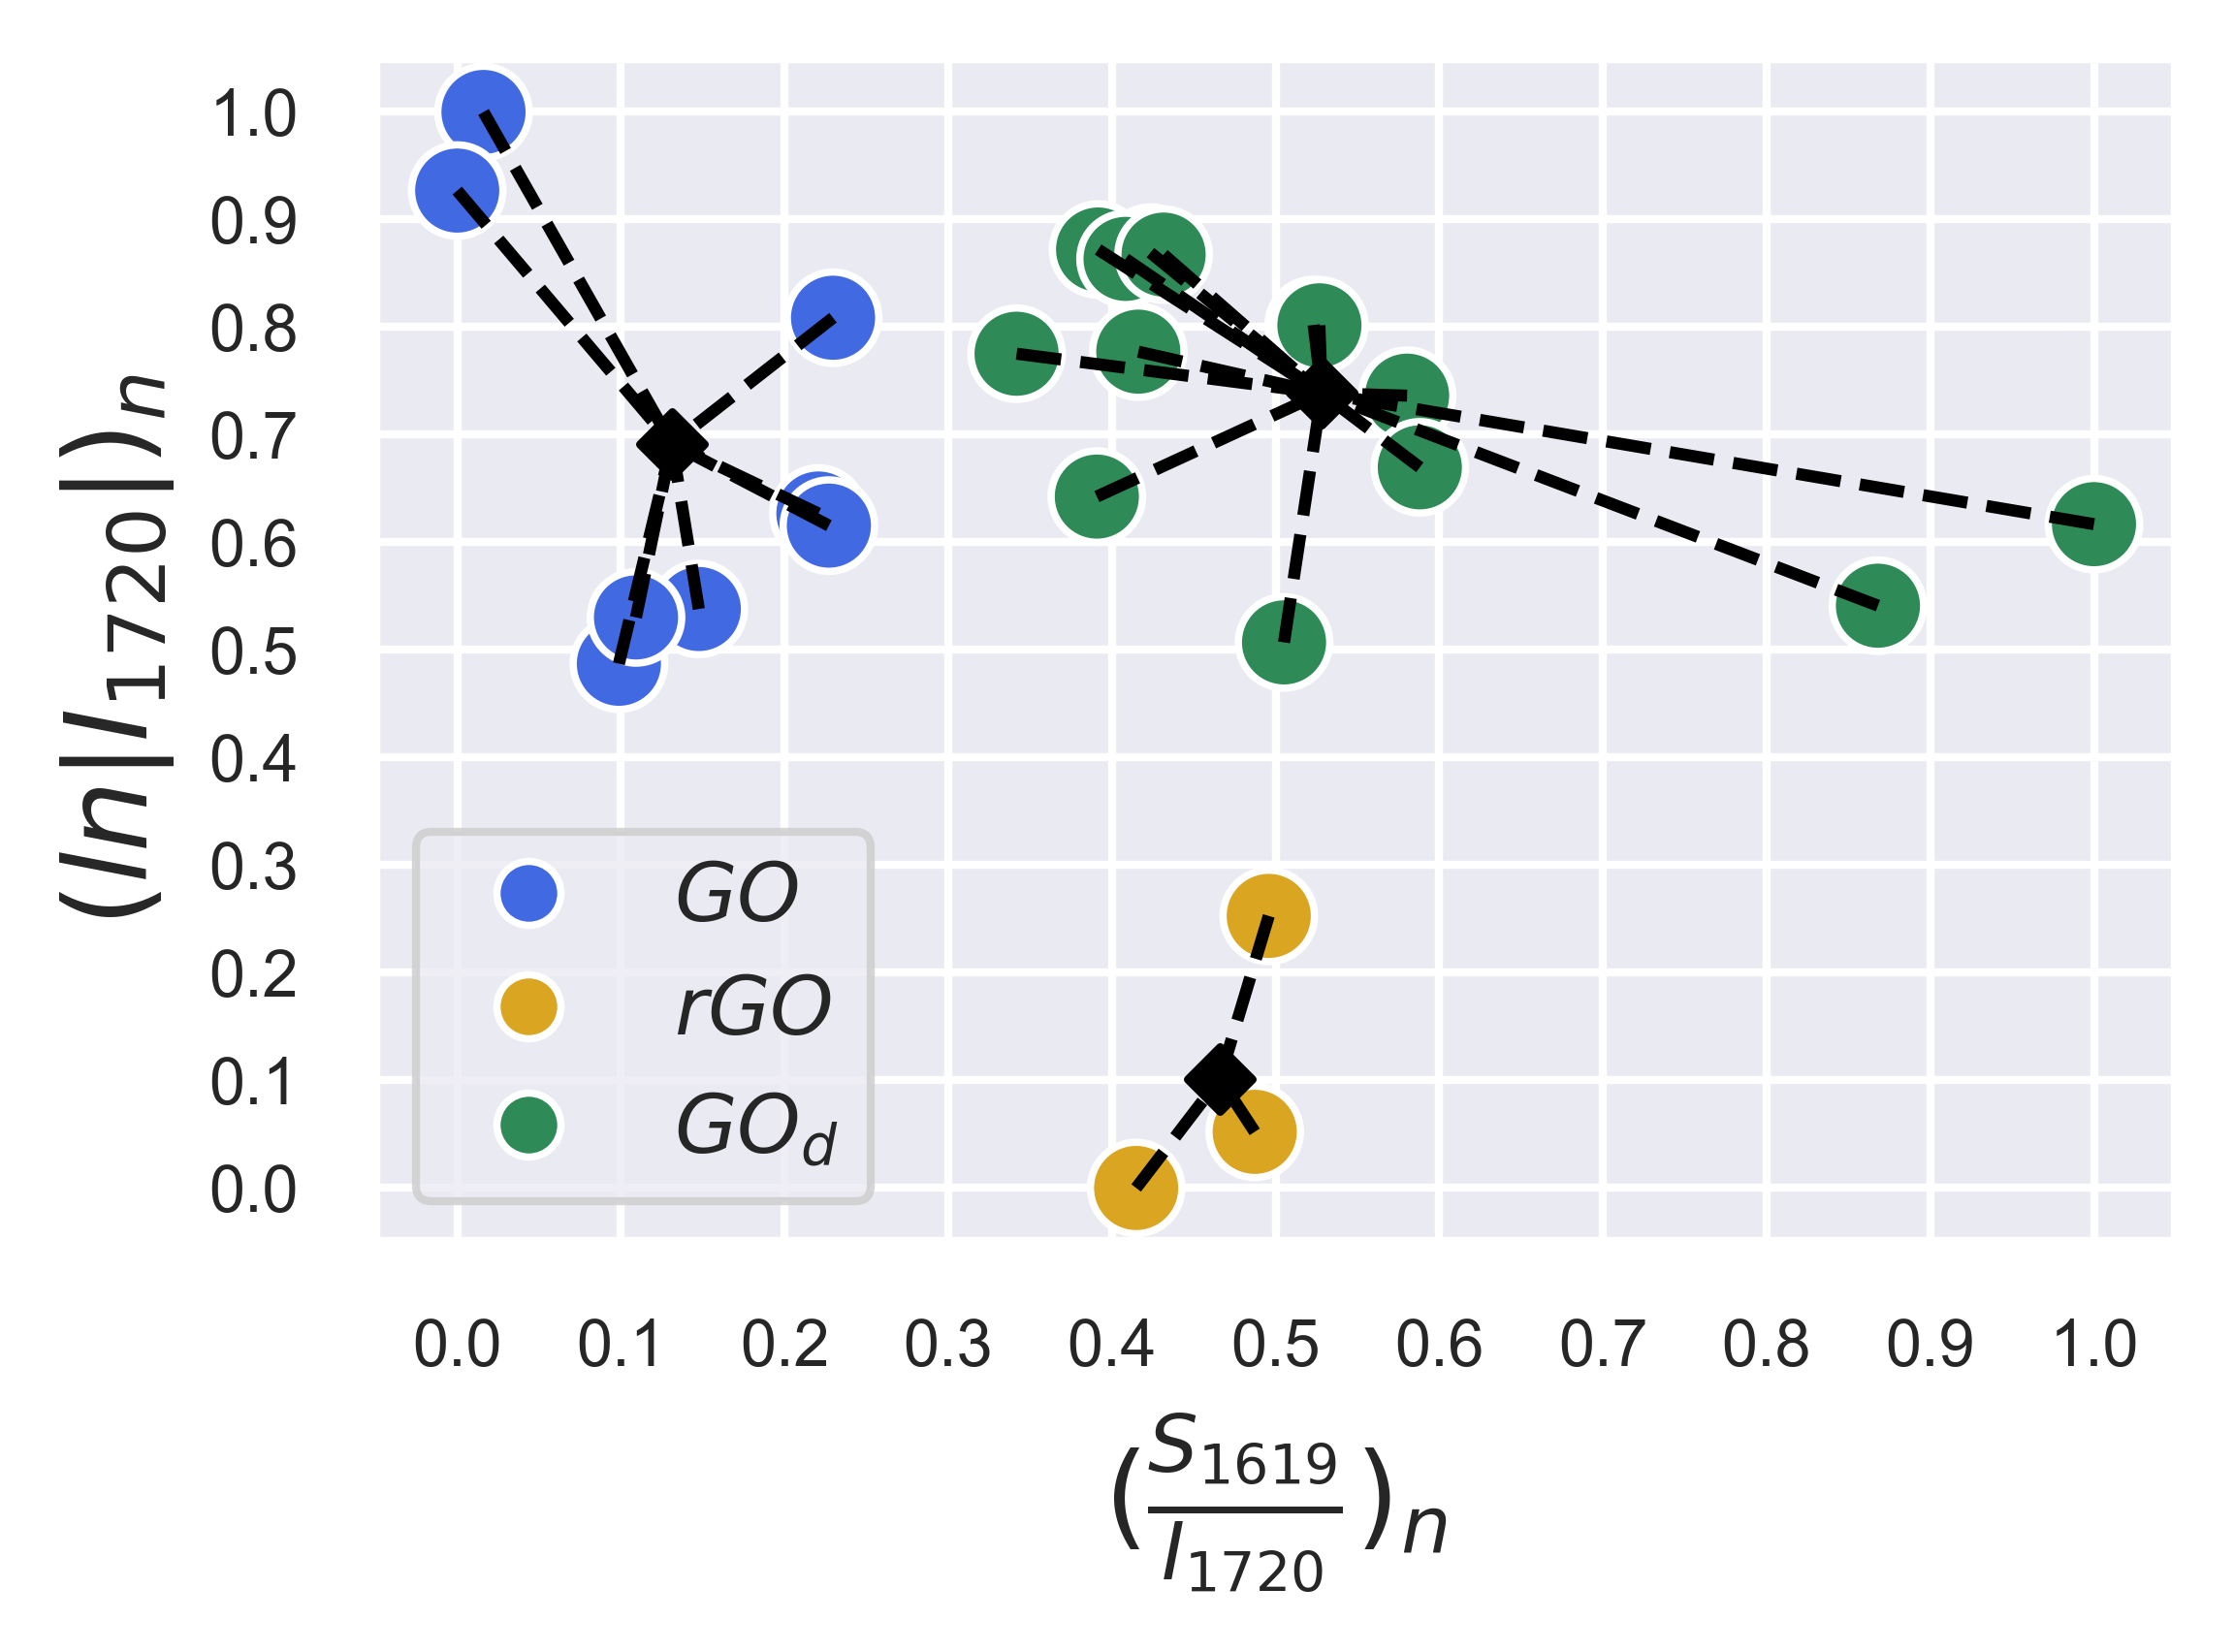

In [30]:
analyzer.get_clustering_visualization(
    figsize=(4, 3),
    markersize=128,
    palette=type_color_dict,
    color=None,
    fontsize=14,
    print_point_labels=False,
    filter_class=None,
    path_to_save=f'{path_to_graphical_abstract}/scatterplot.png',
    dpi=600
)